In [2]:
%load_ext autoreload
%autoreload 2

import sys, os
import requests
import pandas as pd
import json
import talib
import numpy as np
import time

import yfinance as yf
import warnings
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

# Load API keys - search in multiple locations
def find_secrets():
    """Find secrets.json in current dir, parent dir, or submodules dir."""
    possible_paths = [
        "../secrets.json",  # Parent directory (markets/)
    ]
    for path in possible_paths:
        if os.path.exists(path):
            print(f"✓ Found secrets at: {path}")
            return path
    raise FileNotFoundError(
        "secrets.json not found. Searched locations:\n" + "\n".join(f"  - {p}" for p in possible_paths)
    )

SECRET_FP = find_secrets()
with open(SECRET_FP, 'r') as file:
    secrets = json.load(file)
API_KEY = secrets['eodhd_api_key']

# Import from package (works if installed with pip install -e .)
try:
    from markets.submodules import Chain, ChainHistory, Security, Index
    from markets.submodules.fa import FundamentalAnalysis
    from markets.submodules import plot
    from markets.submodules.plot import ChartStyle
    print("✓ Using installed markets package")
except ImportError:
    print("⚠ Package not installed, using local imports")
    
    # Try to find the submodules directory
    current_dir = os.getcwd()
    parent_dir = os.path.dirname(current_dir)
    
    # Check for markets/submodules (if we're in markets/implementations)
    submodules_path = os.path.join(parent_dir, 'submodules')
    
    if os.path.exists(submodules_path):
        sys.path.insert(0, submodules_path)
        print(f"  Added to path: {submodules_path}")
    
    from eodhd import Chain, ChainHistory, Security, Index
    import plot
    from plot import ChartStyle

cs = ChartStyle(figsize=(20,8),nyears=1, date_fmt="%Y-%m", grid=False)

###########################################################################
REFRESH = True
###########################################################################


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✓ Found secrets at: ../secrets.json
⚠ Package not installed, using local imports
  Added to path: c:\Users\msands\OneDrive\Documents\code\markets\submodules


# Fields

In [5]:
BASE_FUNDAMENTAL_FIELDS = [

    'Earnings::History::epsActual',
    'Earnings::History::epsEstimate',

    'Earnings::History::date',
    'Earnings::History::reportDate',

    'Financials::Cash_Flow::freeCashFlow',
    'Financials::Cash_Flow::totalCashFromFinancingActivities',
    'Financials::Cash_Flow::totalCashFromOperatingActivities',
    'Financials::Cash_Flow::otherCashflowsFromFinancingActivities',
    'Financials::Cash_Flow::totalCashflowsFromInvestingActivities',
    'Financials::Cash_Flow::changeInWorkingCapital',
    'Financials::Cash_Flow::capitalExpenditures',

    'Financials::Income_Statement::totalRevenue',
    'Financials::Income_Statement::totalOperatingExpenses',
    'Financials::Income_Statement::costOfRevenue',
    'Financials::Income_Statement::netIncomeFromContinuingOps',
    'Financials::Income_Statement::netIncomeApplicableToCommonShares',
    'Financials::Income_Statement::researchDevelopment',
    'Financials::Income_Statement::netIncome',
    'Financials::Income_Statement::grossProfit',
    'Financials::Income_Statement::ebit',
    'Financials::Income_Statement::ebitda',
    'Financials::Income_Statement::operatingIncome',

    'Financials::Balance_Sheet::totalAssets',
    'Financials::Balance_Sheet::intangibleAssets',
    'Financials::Balance_Sheet::totalLiab',
    'Financials::Balance_Sheet::totalStockholderEquity',
    'Financials::Balance_Sheet::retainedEarnings',
    'Financials::Balance_Sheet::cash',
    'Financials::Balance_Sheet::cashAndEquivalents',
    'Financials::Balance_Sheet::totalCurrentLiabilities',
    'Financials::Balance_Sheet::shortTermDebt',
    'Financials::Balance_Sheet::shortLongTermDebt',
    'Financials::Balance_Sheet::shortLongTermDebtTotal',
    'Financials::Balance_Sheet::propertyPlantEquipment',
    'Financials::Balance_Sheet::totalCurrentAssets',
    'Financials::Balance_Sheet::netReceivables',
    'Financials::Balance_Sheet::longTermDebt',
    'Financials::Balance_Sheet::inventory',
    'Financials::Balance_Sheet::accountsPayable',
    'Financials::Balance_Sheet::additionalPaidInCapital',
    'Financials::Balance_Sheet::commonStockTotalEquity',
    'Financials::Balance_Sheet::preferredStockTotalEquity',
    'Financials::Balance_Sheet::retainedEarningsTotalEquity',
    'Financials::Balance_Sheet::nonCurrentAssetsTotal',
    'Financials::Balance_Sheet::longTermDebtTotal',
    'Financials::Balance_Sheet::cashAndShortTermInvestments',
    'Financials::Balance_Sheet::propertyPlantAndEquipmentGross',
    'Financials::Balance_Sheet::propertyPlantAndEquipmentNet',
    'Financials::Balance_Sheet::commonStockSharesOutstanding',
    'Financials::Balance_Sheet::netWorkingCapital',

    'Valuation::ForwardPE',
    'Valuation::TrailingPE',
    'Technicals::Beta',

    'Highlights::MarketCapitalization',
    # 'Highlights::PERatio',
    # 'Highlights::EBITDA',

    # 'SharesStats::SharesOutstanding',
    # 'SharesStats::SharesFloat',
    # 'SharesStats::ShortPercentFloat',

    # 'Highlights::PEGRatio',
    # 'Highlights::BookValue',
    # 'Highlights::DividendYield',
    # 'Highlights::EarningsShare',
    # 'Highlights::EPSEstimateCurrentYear',
    # 'Highlights::EPSEstimateNextYear',
    # 'Highlights::ProfitMargin',
    # 'Highlights::OperatingMarginTTM',
    # 'Highlights::ReturnOnAssetsTTM',
    # 'Highlights::ReturnOnEquityTTM',

    # not using
    # 'Financials::Income_Statement::eps',
    # 'Highlights::SharesOutstanding',

    ]

# Index Constituents

In [6]:
idx = Index('XLG.US')

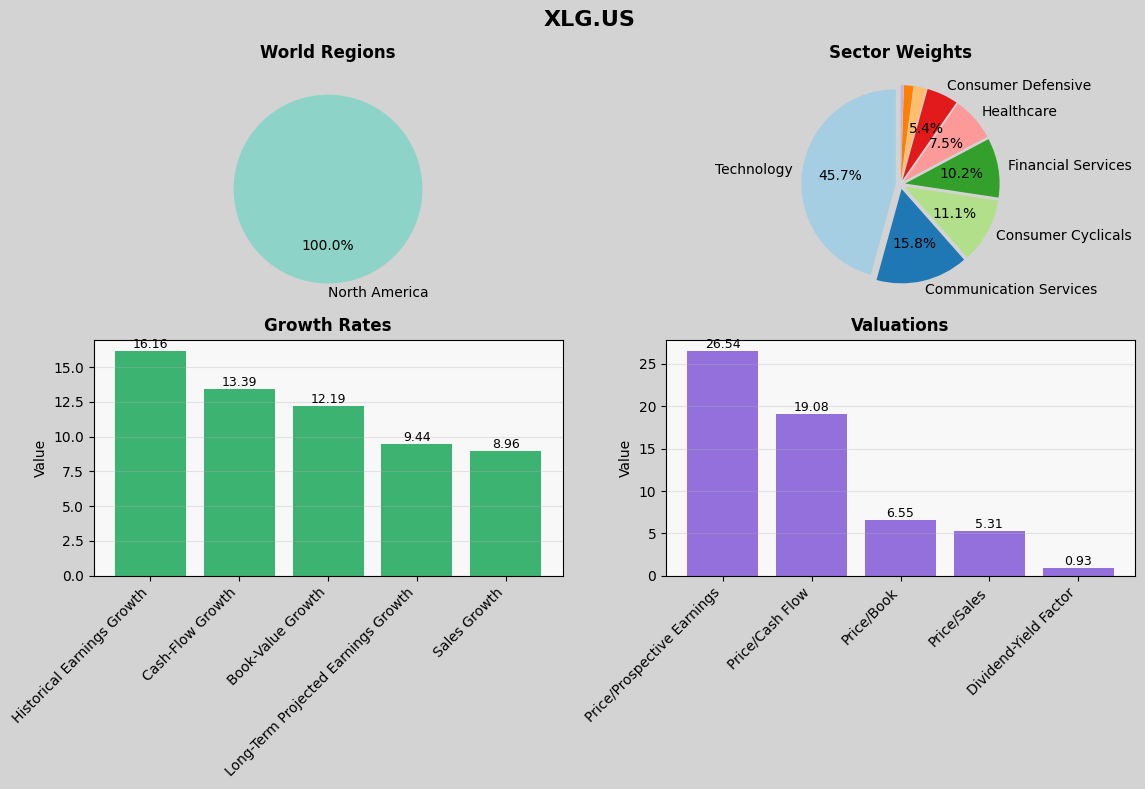

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.patch.set_facecolor('lightgrey')  # Set figure background
fig.suptitle(f'{idx.ticker}', fontsize=16, fontweight='bold')

# 1. World Regions (top-left) - Pie Chart
df_regions = idx.get_world_regions()
if not df_regions.empty:
    explode = [0.05] * len(df_regions)
    # Only show labels for slices >= 5%
    labels = [region if pct >= 5 else '' for region, pct in zip(df_regions['Region'], df_regions['Equity_%'])]
    autopct = lambda pct: f'{pct:.1f}%' if pct >= 5 else ''
    
    axes[0, 0].pie(df_regions['Equity_%'], labels=labels, autopct=autopct, 
                   startangle=90, explode=explode, colors=plt.cm.Set3.colors)
    axes[0, 0].set_title('World Regions', fontsize=12, fontweight='bold')
    axes[0, 0].set_facecolor('#f8f8f8')

# 2. Sector Weights (top-right) - Pie Chart
df_sectors = idx.get_sector_weights()
if not df_sectors.empty:
    explode = [0.05] * len(df_sectors)
    # Only show labels for slices >= 5%
    labels = [sector if pct >= 5 else '' for sector, pct in zip(df_sectors['Sector'], df_sectors['Equity_%'])]
    autopct = lambda pct: f'{pct:.1f}%' if pct >= 5 else ''
    
    axes[0, 1].pie(df_sectors['Equity_%'], labels=labels, autopct=autopct, 
                   startangle=90, explode=explode, colors=plt.cm.Paired.colors)
    axes[0, 1].set_title('Sector Weights', fontsize=12, fontweight='bold')
    axes[0, 1].set_facecolor('#f8f8f8')

# 3. Growth Rates (bottom-left) - Vertical Bar Chart
df_growth = idx.get_growth_rates()
if not df_growth.empty:
    # Convert Value to numeric, removing any % signs or other formatting
    df_growth['Value_Numeric'] = pd.to_numeric(df_growth['Value'].astype(str).str.replace('%', '').str.replace(',', ''), errors='coerce')
    # Sort by numeric value descending
    df_growth_sorted = df_growth.sort_values('Value_Numeric', ascending=False)
    x_pos = range(len(df_growth_sorted))
    bars = axes[1, 0].bar(x_pos, df_growth_sorted['Value_Numeric'], color='mediumseagreen')
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(df_growth_sorted['Metric'], rotation=45, ha='right')
    axes[1, 0].set_ylabel('Value', fontsize=10)
    axes[1, 0].set_title('Growth Rates', fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)
    axes[1, 0].set_facecolor('#f8f8f8')
    # Annotate bars
    for bar, val in zip(bars, df_growth_sorted['Value_Numeric']):
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                        f'{val:.2f}', ha='center', va='bottom', fontsize=9)

# 4. Valuations (bottom-right) - Vertical Bar Chart
df_valuations = idx.get_valuations()
if not df_valuations.empty:
    # Convert Value to numeric, removing any % signs or other formatting
    df_valuations['Value_Numeric'] = pd.to_numeric(df_valuations['Value'].astype(str).str.replace('%', '').str.replace(',', ''), errors='coerce')
    # Sort by numeric value descending
    df_valuations_sorted = df_valuations.sort_values('Value_Numeric', ascending=False)
    x_pos = range(len(df_valuations_sorted))
    bars = axes[1, 1].bar(x_pos, df_valuations_sorted['Value_Numeric'], color='mediumpurple')
    axes[1, 1].set_xticks(x_pos)
    axes[1, 1].set_xticklabels(df_valuations_sorted['Metric'], rotation=45, ha='right')
    axes[1, 1].set_ylabel('Value', fontsize=10)
    axes[1, 1].set_title('Valuations', fontsize=12, fontweight='bold')
    axes[1, 1].grid(axis='y', alpha=0.3)
    axes[1, 1].set_facecolor('#f8f8f8')
    # Annotate bars
    for bar, val in zip(bars, df_valuations_sorted['Value_Numeric']):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                        f'{val:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

<Axes: xlabel='Ticker'>

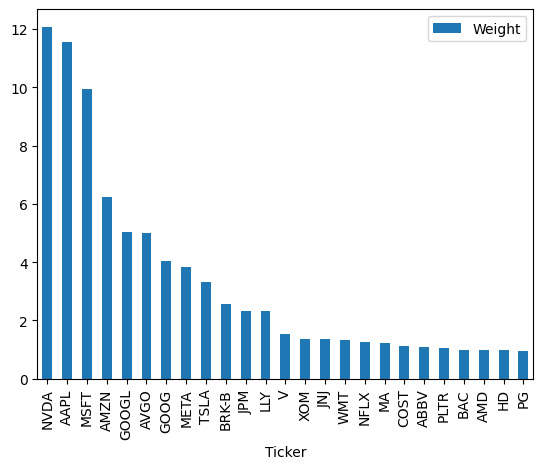

In [8]:
idx.get_constituents()[['Ticker', 'Weight', 'Sector']].set_index('Ticker').plot.bar()

# Fundamental Data

In [9]:
if REFRESH:
    print('...Refreshing data...')

    print(f"Fetching {idx.ticker} tickers...")
    constituent_tickers = idx.get_constituents()

    display(constituent_tickers.head(5))
    assert(np.isclose(constituent_tickers['Weight'].sum(), 1.0, rtol=.1), 'Assertion Failed: Index constituent weights returned do not sum to 100%')

    df_fun = idx.fetch_constituent_fundamentals(field_paths=BASE_FUNDAMENTAL_FIELDS, period = 'quarterly', date = '2025-09-30')

    df_fun.set_index('Ticker', inplace=True)
    df_fun.to_pickle(os.path.join(r"C:\Users\msands\OneDrive\Documents\\data\\EODHD Fundamentals", f"{idx.ticker}_constituent_fundamentals.pkl"))

else:
    print('...Loading cached data...')
    df_fun = pd.read_pickle(os.path.join(r"C:\Users\msands\OneDrive\Documents\\data\\", f"{idx.ticker}_constituent_fundamentals.pkl"))

...Refreshing data...
Fetching XLG.US tickers...


,Ticker,Name,Weight,Sector,Industry,Exchange
0,NVDA,NVIDIA Corporation,12.07660,Technology,Semiconductors,NaN
1,AAPL,Apple Inc,11.55739,Technology,Consumer Electronics,NaN
2,MSFT,Microsoft Corporation,9.95267,Technology,Software - Infrastructure,NaN
3,AMZN,Amazon.com Inc,6.24397,Consumer Cyclical,Internet Retail,NaN
4,GOOGL,Alphabet Inc Class A,5.03892,Communication Services,Internet Content & Information,NaN



Fetching 54 fields (parallel with 10 threads)...
Fields: epsActual, epsEstimate, date, reportDate, freeCashFlow, totalCashFromFinancingActivities, totalCashFromOperatingActivities, otherCashflowsFromFinancingActivities, totalCashflowsFromInvestingActivities, changeInWorkingCapital, capitalExpenditures, totalRevenue, totalOperatingExpenses, costOfRevenue, netIncomeFromContinuingOps, netIncomeApplicableToCommonShares, researchDevelopment, netIncome, grossProfit, ebit, ebitda, operatingIncome, totalAssets, intangibleAssets, totalLiab, totalStockholderEquity, retainedEarnings, cash, cashAndEquivalents, totalCurrentLiabilities, shortTermDebt, shortLongTermDebt, shortLongTermDebtTotal, propertyPlantEquipment, totalCurrentAssets, netReceivables, longTermDebt, inventory, accountsPayable, additionalPaidInCapital, commonStockTotalEquity, preferredStockTotalEquity, retainedEarningsTotalEquity, nonCurrentAssetsTotal, longTermDebtTotal, cashAndShortTermInvestments, propertyPlantAndEquipmentGross, 

100%|██████████| 25/25 [00:03<00:00,  7.68it/s]


In [10]:
print(idx.ticker)
print(df_fun.shape)
# print(df_fun.columns)

XLG.US
(25, 89)


In [11]:
df_fun[[c for c in df_fun.columns if 'dt_' in c]].head()

,dt_epsActual,dt_epsReport,dt_FYE,dt_CQ_Earnings,dt_CQ_Income_Statement,dt_CQ_Balance_Sheet,dt_CQ_Cash_Flow
Ticker,,,,,,,
GOOG,2025-09-30,2025-10-28,2025Q3,2025Q3,2025-09-30,2025-09-30,2025-09-30
TSLA,2025-09-30,2025-10-22,2025Q3,2025Q3,2025-09-30,2025-09-30,2025-09-30
AVGO,2025-07-31,2025-09-04,2025Q4,2025Q2,2025-07-31,2025-07-31,2025-07-31
META,2025-09-30,2025-10-29,2025Q3,2025Q3,2025-09-30,2025-09-30,2025-09-30
GOOGL,2025-09-30,2025-10-29,2025Q3,2025Q3,2025-09-30,2025-09-30,2025-09-30


# Cross Sectional Analysis

In [12]:
fa = FundamentalAnalysis(df=df_fun)

In [13]:
df_ltm = fa._calculate_derived_metrics(ltm=True)
metrics = [c for c in df_ltm.columns if c.startswith('_')]
df_ltm = df_ltm[metrics]
df_ltm.head()

,_PriceToEarnings,_PriceToFwdEarnings,_PriceToSales,_PriceToBook,_PriceToFCF,_EV_to_EBITDA,_EV_to_Sales,_GrossProfitMargin,_OperatingProfitMargin,_NetProfitMargin,...,_TangibleBookValuePerShare,_DuPont_NetMargin,_DuPont_AssetTurnover,_DuPont_EquityMultiplier,_DuPont_ROE,_Value_Score,_DeepValue_Score,_Quality_Score,_Profitability_Score,_Growth_Score
Ticker,,,,,,,,,,,,,,,,,,,,,
GOOG,30.610204,29.309050,10.040732,10.004656,52.622243,22.527647,10.036885,59.172143,32.187913,32.233052,...,NaN,0.322331,0.718545,1.386701,0.321172,50.500000,49.333333,60.257576,71.109091,56.666667
TSLA,268.393184,NaN,15.536231,18.579172,217.409475,111.443908,15.397492,17.006682,4.735813,5.552477,...,22.642938,0.055525,0.715093,1.672315,0.066400,13.000000,14.666667,50.363636,13.236364,26.000000
AVGO,58.796679,54.871085,29.993312,24.528559,72.097040,58.211135,30.862801,66.827420,37.718186,31.592297,...,8.010905,0.315923,0.361826,2.260204,0.258362,11.136364,20.000000,49.969697,58.363636,58.000000
META,21.733700,21.621246,8.509210,8.307119,35.952128,15.943144,8.607633,81.996970,43.226167,30.892498,...,NaN,0.308925,0.623534,1.565674,0.301588,60.772727,65.333333,68.606061,72.727273,75.000000
GOOGL,31.286949,29.901005,10.043135,10.007051,52.634839,22.533041,10.039288,59.172143,32.187913,32.233052,...,NaN,0.322331,0.718545,1.386701,0.321172,46.363636,45.333333,60.257576,71.109091,55.000000


In [14]:
df_ltm['_FCFPerShare']

Ticker
GOOG      6.027370
TSLA      1.938174
AVGO      5.129630
META     17.434292
GOOGL     6.027370
AMZN      0.973721
NVDA      3.158273
BRK-B     8.952308
AAPL      6.582405
MSFT     10.449638
V         9.929590
JPM     -13.051151
LLY      10.036382
NFLX      2.060027
XOM       5.489494
MA       18.793370
WMT       4.051055
ABBV     11.607788
COST     17.622879
JNJ       7.849790
PLTR      0.700442
BAC       8.059682
HD       14.011066
PG        6.132223
AMD       3.319927
Name: _FCFPerShare, dtype: float64

In [15]:
df_pct = fa.calculate_percentile_ranks(by_sector=False)

## Z-Scores

In [16]:
df_z = fa.calculate_z_scores(by_sector=False)
df_z.head()

,_PriceToEarnings,_PriceToFwdEarnings,_PriceToSales,_PriceToBook,_PriceToFCF,_EV_to_EBITDA,_EV_to_Sales,_GrossProfitMargin,_OperatingProfitMargin,_NetProfitMargin,...,_TangibleBookValuePerShare,_DuPont_NetMargin,_DuPont_AssetTurnover,_DuPont_EquityMultiplier,_DuPont_ROE,_Value_Score,_DeepValue_Score,_Quality_Score,_Profitability_Score,_Growth_Score
Ticker,,,,,,,,,,,,,,,,,,,,,
GOOG,-0.312618,-0.243078,-0.149473,-0.054628,-0.139592,-0.282489,-0.011749,0.204493,0.288054,0.633881,...,NaN,0.633881,-0.127050,0.006162,-0.131254,0.100842,2.974783e-16,0.591451,0.773215,0.245011
TSLA,3.403862,NaN,0.120483,0.163266,2.338355,3.611317,0.709239,-1.753907,-1.319357,-1.219540,...,-0.199273,-1.219540,-0.131620,0.031493,-0.614899,-1.368686,-1.451367e+00,-0.059404,-1.523313,-1.185257
AVGO,0.127929,0.339655,0.830658,0.314451,0.153256,1.280156,2.789281,0.560047,0.611870,0.589370,...,-0.383096,0.589370,-0.599296,0.083633,-0.250490,-1.441717,-1.228080e+00,-0.085319,0.267445,0.307197
META,-0.451355,-0.418335,-0.224706,-0.097766,-0.390264,-0.570837,-0.203979,1.264606,0.934381,0.540757,...,NaN,0.540757,-0.252831,0.022035,-0.168432,0.503404,6.698616e-01,1.140640,0.837428,1.100063
GOOGL,-0.302040,-0.229583,-0.149355,-0.054567,-0.139402,-0.282253,-0.011425,0.204493,0.288054,0.633881,...,NaN,0.633881,-0.127050,0.006162,-0.131254,-0.061251,-1.674654e-01,0.591451,0.773215,0.167279


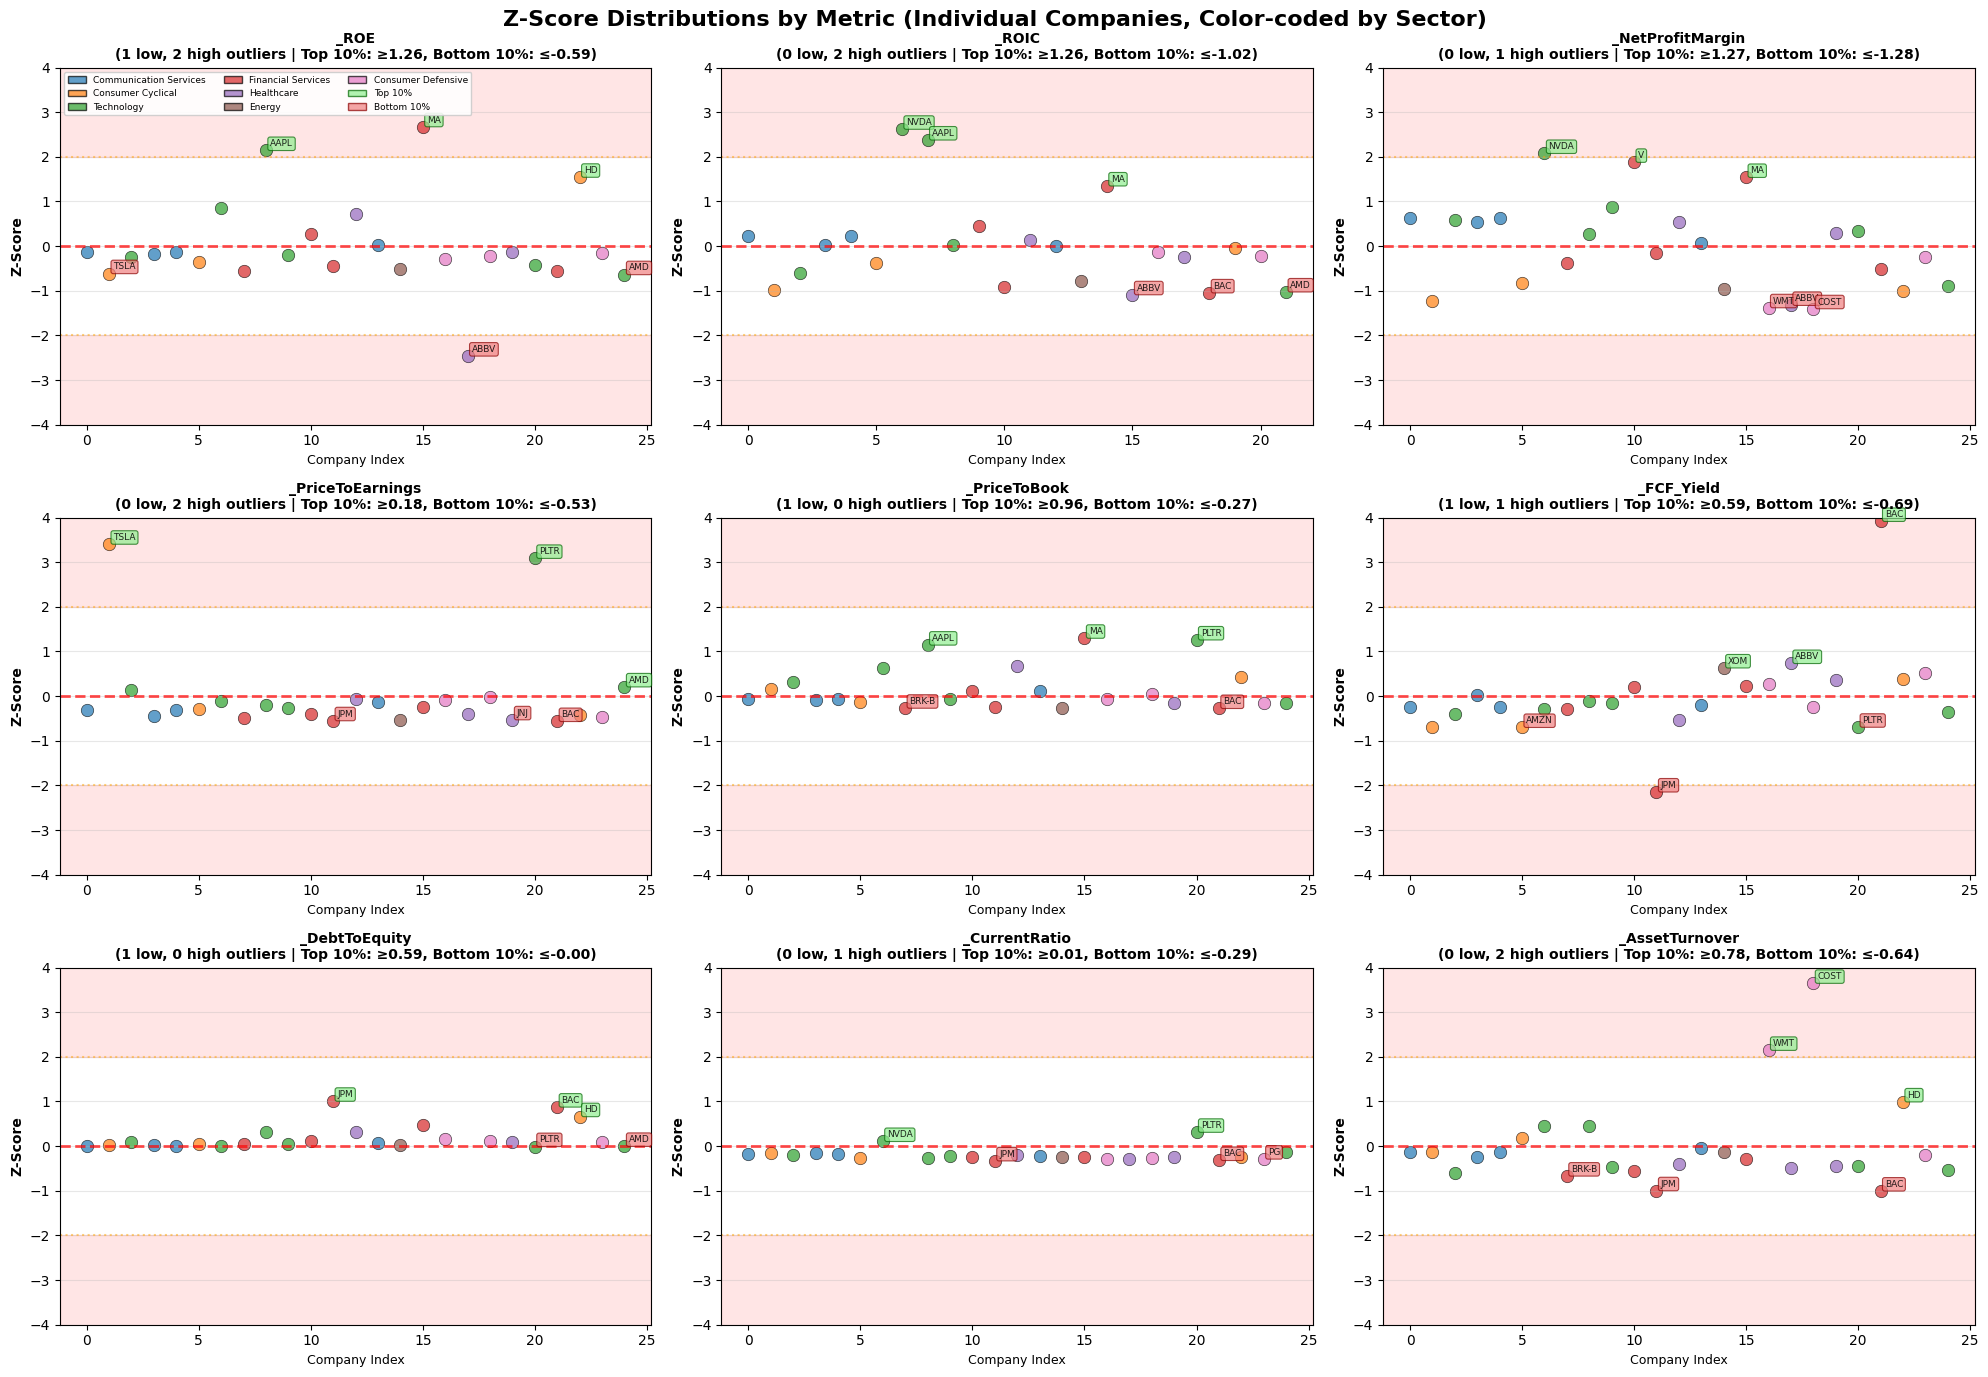


TOP & BOTTOM 10% COMPANIES BY METRIC

_ROE:
  Top 10% (≥1.26): MA, AAPL, HD
  Bottom 10% (≤-0.59): ABBV, AMD, TSLA

_ROIC:
  Top 10% (≥1.26): NVDA, AAPL, MA
  Bottom 10% (≤-1.02): ABBV, BAC, AMD

_NetProfitMargin:
  Top 10% (≥1.27): NVDA, V, MA
  Bottom 10% (≤-1.28): COST, WMT, ABBV

_PriceToEarnings:
  Top 10% (≥0.18): TSLA, PLTR, AMD
  Bottom 10% (≤-0.53): BAC, JPM, JNJ

_PriceToBook:
  Top 10% (≥0.96): MA, PLTR, AAPL
  Bottom 10% (≤-0.27): ABBV, BAC, BRK-B

_FCF_Yield:
  Top 10% (≥0.59): BAC, ABBV, XOM
  Bottom 10% (≤-0.69): JPM, AMZN, PLTR

_DebtToEquity:
  Top 10% (≥0.59): JPM, BAC, HD
  Bottom 10% (≤-0.00): ABBV, PLTR, AMD

_CurrentRatio:
  Top 10% (≥0.01): BRK-B, PLTR, NVDA
  Bottom 10% (≤-0.29): JPM, BAC, PG

_AssetTurnover:
  Top 10% (≥0.78): COST, WMT, HD
  Bottom 10% (≤-0.64): BAC, JPM, BRK-B

OUTLIER SUMMARY BY SECTOR

_ROE:
  Financial Services: 1 outliers
  Healthcare: 1 outliers
  Technology: 1 outliers

_ROIC:
  Technology: 2 outliers

_NetProfitMargin:
  Technology: 1

In [17]:
# 2. Company-level scatter plots: Individual companies color-coded by sector
fig, axes = plt.subplots(3, 3, figsize=(20, 14))
fig.suptitle('Z-Score Distributions by Metric (Individual Companies, Color-coded by Sector)', 
             fontsize=16, fontweight='bold')

# Select key metrics to visualize
key_metrics = ['_ROE', '_ROIC', '_NetProfitMargin', '_PriceToEarnings', '_PriceToBook', 
               '_FCF_Yield', '_DebtToEquity', '_CurrentRatio', '_AssetTurnover']

# Merge sector information with z-scores
df_z_with_sector = df_z.copy()
df_z_with_sector['Sector'] = df_fun['Sector']

# Define sector color palette
sectors = df_z_with_sector['Sector'].dropna().unique()
sector_colors = dict(zip(sectors, plt.cm.tab10(range(len(sectors)))))

for idx, metric in enumerate(key_metrics[:9]):
    if metric in df_z.columns:
        ax = axes[idx // 3, idx % 3]
        
        # Get data with sector
        data = df_z_with_sector[[metric, 'Sector']].dropna()
        
        # Plot each sector separately for color-coding
        for sector in sectors:
            sector_data = data[data['Sector'] == sector]
            if not sector_data.empty:
                # X-axis: sequential company positions, Y-axis: z-score
                x_positions = [i for i, s in enumerate(data['Sector']) if s == sector]
                y_values = sector_data[metric].values
                
                # Only add to legend on first subplot
                ax.scatter(x_positions, y_values, 
                          c=[sector_colors[sector]], 
                          label=sector if idx == 0 else '',
                          alpha=0.7, s=80, edgecolors='black', linewidth=0.5)
        
        # Add reference lines
        ax.axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.7)
        ax.axhline(-2, color='orange', linestyle=':', linewidth=1.5, alpha=0.5)
        ax.axhline(2, color='orange', linestyle=':', linewidth=1.5, alpha=0.5)
        
        # Shade outlier regions
        ax.axhspan(-5, -2, alpha=0.1, color='red', zorder=0)
        ax.axhspan(2, 5, alpha=0.1, color='red', zorder=0)
        
        # Count outliers
        outliers_low = (data[metric] < -2).sum()
        outliers_high = (data[metric] > 2).sum()
        
        # Calculate top and bottom 10% thresholds
        top_10_threshold = data[metric].quantile(0.90)
        bottom_10_threshold = data[metric].quantile(0.10)
        
        # Identify top and bottom 10% companies
        top_10_pct = data[data[metric] >= top_10_threshold]
        bottom_10_pct = data[data[metric] <= bottom_10_threshold]
        
        # Annotate top 10% (green background)
        for ticker in top_10_pct.index:
            ticker_position = data.index.get_loc(ticker)
            z_value = data.loc[ticker, metric]
            ax.annotate(ticker, 
                       xy=(ticker_position, z_value),
                       fontsize=6.5, alpha=0.85,
                       xytext=(3, 3), textcoords='offset points',
                       bbox=dict(boxstyle='round,pad=0.25', facecolor='lightgreen', 
                                alpha=0.7, edgecolor='darkgreen', linewidth=0.8))
        
        # Annotate bottom 10% (red background)
        for ticker in bottom_10_pct.index:
            ticker_position = data.index.get_loc(ticker)
            z_value = data.loc[ticker, metric]
            ax.annotate(ticker, 
                       xy=(ticker_position, z_value),
                       fontsize=6.5, alpha=0.85,
                       xytext=(3, 3), textcoords='offset points',
                       bbox=dict(boxstyle='round,pad=0.25', facecolor='lightcoral', 
                                alpha=0.7, edgecolor='darkred', linewidth=0.8))
        
        ax.set_title(f'{metric}\n({outliers_low} low, {outliers_high} high outliers | Top 10%: ≥{top_10_threshold:.2f}, Bottom 10%: ≤{bottom_10_threshold:.2f})', 
                    fontsize=10, fontweight='bold')
        ax.set_xlabel('Company Index', fontsize=9)
        ax.set_ylabel('Z-Score', fontsize=10, fontweight='bold')
        ax.set_ylim(-4, 4)
        ax.grid(alpha=0.3, axis='y')
        
        # Only show legend on first plot
        if idx == 0:
            # Add custom legend entries for annotations
            from matplotlib.patches import Patch
            legend_elements = [Patch(facecolor=sector_colors[s], edgecolor='black', 
                                    label=s, alpha=0.7) for s in sectors]
            legend_elements.extend([
                Patch(facecolor='lightgreen', edgecolor='darkgreen', label='Top 10%', alpha=0.7),
                Patch(facecolor='lightcoral', edgecolor='darkred', label='Bottom 10%', alpha=0.7)
            ])
            ax.legend(handles=legend_elements, fontsize=6.5, loc='upper left', 
                     ncol=3, framealpha=0.9)

plt.tight_layout()
plt.show()

# Print summary by sector
print("\n" + "=" * 80)
print("TOP & BOTTOM 10% COMPANIES BY METRIC")
print("=" * 80)
for metric in key_metrics[:9]:
    if metric in df_z.columns:
        data = df_z_with_sector[[metric, 'Sector']].dropna()
        top_10_threshold = data[metric].quantile(0.90)
        bottom_10_threshold = data[metric].quantile(0.10)
        
        top_10_pct = data[data[metric] >= top_10_threshold].sort_values(metric, ascending=False)
        bottom_10_pct = data[data[metric] <= bottom_10_threshold].sort_values(metric)
        
        print(f"\n{metric}:")
        print(f"  Top 10% (≥{top_10_threshold:.2f}): {', '.join(top_10_pct.index.tolist())}")
        print(f"  Bottom 10% (≤{bottom_10_threshold:.2f}): {', '.join(bottom_10_pct.index.tolist())}")

print("\n" + "=" * 80)
print("OUTLIER SUMMARY BY SECTOR")
print("=" * 80)
for metric in key_metrics[:9]:
    if metric in df_z.columns:
        print(f"\n{metric}:")
        outlier_mask = df_z_with_sector[metric].abs() > 2
        if outlier_mask.any():
            outliers_by_sector = df_z_with_sector[outlier_mask].groupby('Sector').size().sort_values(ascending=False)
            for sector, count in outliers_by_sector.items():
                print(f"  {sector}: {count} outliers")
        else:
            print("  No outliers")

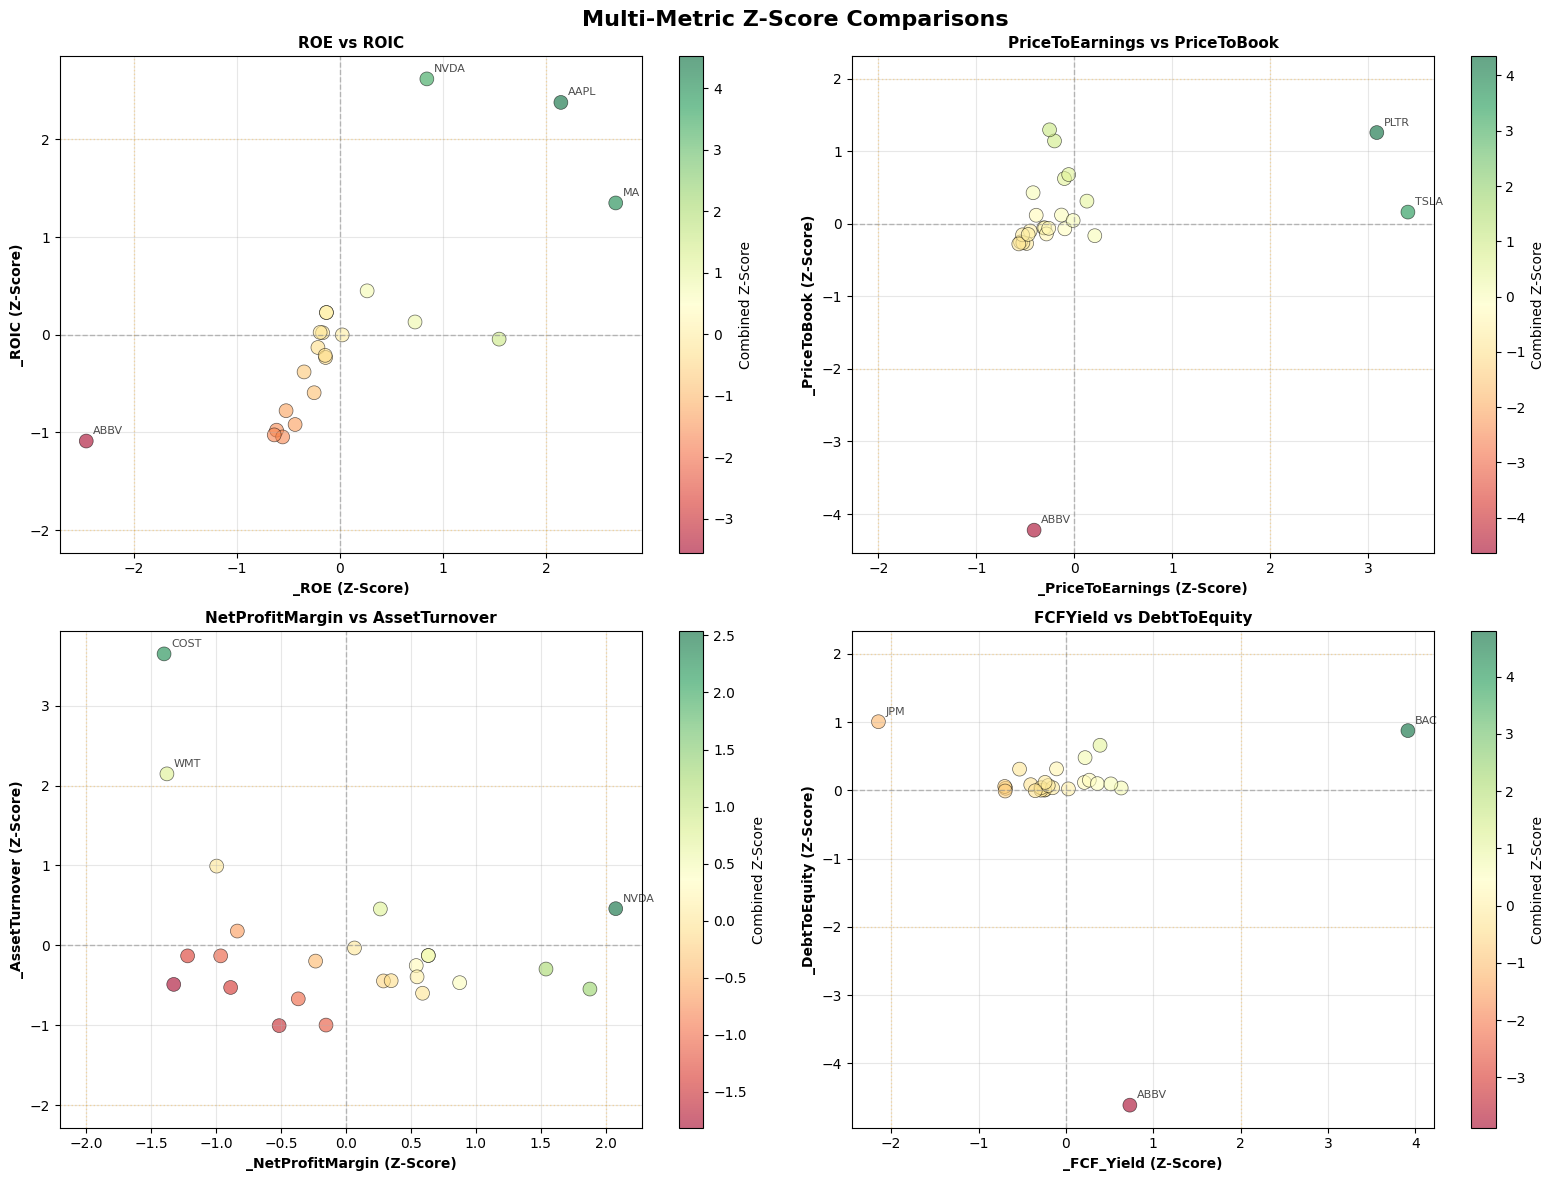

In [18]:
# 3. Scatter plots: Identify multi-dimensional outliers
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Multi-Metric Z-Score Comparisons', fontsize=16, fontweight='bold')

# Define comparison pairs
comparisons = [
    ('_ROE', '_ROIC'),
    ('_PriceToEarnings', '_PriceToBook'),
    ('_NetProfitMargin', '_AssetTurnover'),
    ('_FCF_Yield', '_DebtToEquity')
]

for idx, (metric1, metric2) in enumerate(comparisons):
    ax = axes[idx // 2, idx % 2]
    
    if metric1 in df_z.columns and metric2 in df_z.columns:
        # Plot scatter
        scatter = ax.scatter(df_z[metric1], df_z[metric2], 
                           alpha=0.6, s=100, c=df_z[metric1] + df_z[metric2], 
                           cmap='RdYlGn', edgecolors='black', linewidth=0.5)
        
        # Add reference lines at 0
        ax.axhline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        ax.axvline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
        
        # Add quadrant lines at ±2
        ax.axhline(2, color='orange', linestyle=':', linewidth=1, alpha=0.3)
        ax.axhline(-2, color='orange', linestyle=':', linewidth=1, alpha=0.3)
        ax.axvline(2, color='orange', linestyle=':', linewidth=1, alpha=0.3)
        ax.axvline(-2, color='orange', linestyle=':', linewidth=1, alpha=0.3)
        
        # Label extreme outliers
        extreme_mask = (df_z[metric1].abs() > 2) | (df_z[metric2].abs() > 2)
        for ticker in df_z[extreme_mask].index:
            ax.annotate(ticker, 
                       (df_z.loc[ticker, metric1], df_z.loc[ticker, metric2]),
                       fontsize=8, alpha=0.7, 
                       xytext=(5, 5), textcoords='offset points')
        
        ax.set_xlabel(f'{metric1} (Z-Score)', fontsize=10, fontweight='bold')
        ax.set_ylabel(f'{metric2} (Z-Score)', fontsize=10, fontweight='bold')
        ax.set_title(f'{metric1.replace("_", "")} vs {metric2.replace("_", "")}', 
                    fontsize=11, fontweight='bold')
        ax.grid(alpha=0.3)
        
        # Add colorbar
        plt.colorbar(scatter, ax=ax, label='Combined Z-Score')

plt.tight_layout()
plt.show()

In [19]:
df_sector_ltm = fa._calculate_derived_metrics(ltm=True, by_sector=True)
df_sector_ltm

# df_sector_metrics_ltm = df_sector_metrics_ltm.set_index('Sector')
# df_sector_metrics_ltm[[c for c in df_sector_metrics_ltm.columns if c.startswith('_')]].head()

,Sector,MarketCapitalization,totalRevenue,netIncome,totalAssets,totalStockholderEquity,totalLiab,totalCurrentAssets,totalCurrentLiabilities,longTermDebt,...,_TangibleBookValuePerShare,_DuPont_NetMargin,_DuPont_AssetTurnover,_DuPont_EquityMultiplier,_DuPont_ROE,_Value_Score,_DeepValue_Score,_Quality_Score,_Profitability_Score,_Growth_Score
0,Communication Services,9794510356480,1.003790e+12,3.174613e+11,1.431717e+12,9.937540e+11,4.379628e+11,4.339749e+11,2.457899e+11,8.651102e+10,...,30.676297,0.316263,0.701109,1.440715,0.319457,32.142857,38.095238,69.047619,82.857143,76.190476
1,Consumer Cyclical,4322409709568,9.531520e+11,9.637400e+10,9.679300e+11,4.617170e+11,5.054670e+11,2.976340e+11,2.608530e+11,1.026940e+11,...,29.363488,0.101111,0.984732,2.096371,0.208730,28.571429,19.047619,52.380952,40.000000,33.333333
2,Consumer Defensive,1665413513216,1.063229e+12,4.777400e+10,4.933530e+11,1.785280e+11,3.145440e+11,1.584180e+11,1.908350e+11,3.002800e+10,...,14.386956,0.044933,2.155108,2.763449,0.267599,53.571429,57.142857,66.666667,37.142857,28.571429
3,Energy,502210527232,3.249240e+11,2.995300e+10,4.543400e+11,2.605610e+11,1.861170e+11,8.850500e+10,7.785000e+10,3.282400e+10,...,55.241746,0.092185,0.715156,1.743699,0.114956,85.714286,90.476190,45.238095,25.714286,57.142857
4,Financial Services,3492268441600,9.166520e+11,1.894450e+11,9.342300e+12,1.410633e+12,7.931667e+12,2.787675e+12,6.170472e+12,7.772720e+11,...,84.978240,0.206671,0.098118,6.622771,0.134298,67.857143,66.666667,16.666667,42.857143,52.380952
5,Healthcare,1828165124096,2.112128e+11,4.592510e+10,4.416494e+11,1.004283e+11,3.411206e+11,1.452213e+11,1.304009e+11,1.432526e+11,...,-1.778719,0.217435,0.478236,4.397659,0.457292,28.571429,47.619048,64.285714,77.142857,57.142857
6,Technology,14695048675328,9.929642e+11,3.394534e+11,1.407366e+12,6.963635e+11,7.109047e+11,5.130992e+11,3.562864e+11,1.863420e+11,...,11.114425,0.341859,0.705548,2.021022,0.487466,3.571429,14.285714,69.047619,94.285714,61.904762


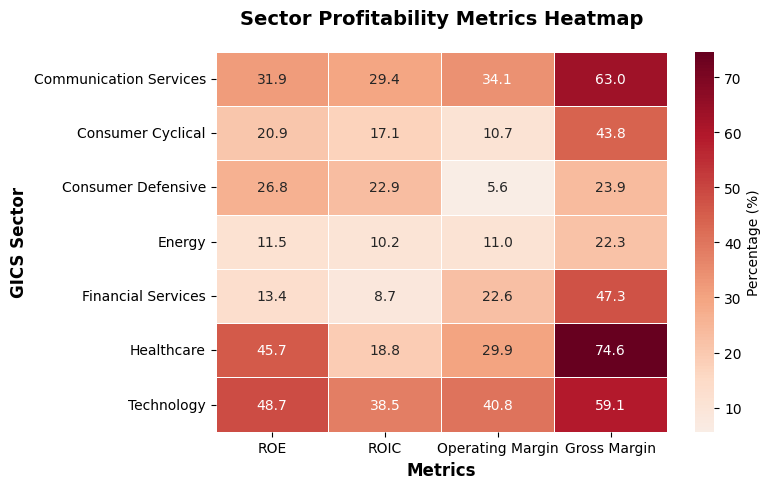

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data for heatmap
metrics_to_plot = ['_ROE', '_ROIC', '_OperatingProfitMargin', '_GrossProfitMargin']
heatmap_data = df_sector_ltm.set_index('Sector')[metrics_to_plot].copy()

# Rename columns for cleaner display
heatmap_data.columns = ['ROE', 'ROIC', 'Operating Margin', 'Gross Margin']

# Create heatmap
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdBu_r', center=0, 
            cbar_kws={'label': 'Percentage (%)'}, linewidths=0.5, ax=ax)

ax.set_title('Sector Profitability Metrics Heatmap', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('GICS Sector', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## Long/Short Factor Portfolios

Construct equal-weighted long/short portfolios for each factor:
- **Long**: Top 10 stocks by factor score (10% weight each = 100% long exposure)
- **Short**: Bottom 10 stocks by factor score (10% weight each = 100% short exposure)
- **Net Exposure**: 0% (market neutral)
- **Gross Exposure**: 200% (100% long + 100% short)

In [21]:
# Construct equal-weighted long/short portfolios for each factor
# Long top 10, short bottom 10 (10% weight each)

factor_columns = ['_Value_Score', '_DeepValue_Score', '_Quality_Score', '_Profitability_Score', '_Growth_Score']
portfolio_names = ['Value', 'Deep Value', 'Quality', 'Profitability', 'Growth']

# Store all portfolios
long_short_portfolios = {}

for factor_col, portfolio_name in zip(factor_columns, portfolio_names):
    # Get top 10 (long positions)
    top_10 = df_ltm.nlargest(10, factor_col)[[factor_col]]
    top_10['Position'] = 'LONG'
    top_10['Weight'] = 0.10  # 10% each = 100% total long
    
    # Get bottom 10 (short positions)
    bottom_10 = df_ltm.nsmallest(10, factor_col)[[factor_col]]
    bottom_10['Position'] = 'SHORT'
    bottom_10['Weight'] = -0.10  # -10% each = -100% total short
    
    # Combine into portfolio - LONG positions first
    portfolio = pd.concat([top_10, bottom_10])
    portfolio = portfolio.rename(columns={factor_col: 'Factor_Score'})
    portfolio['Sector'] = df_fun.loc[portfolio.index, 'Sector']
    portfolio['MarketCap'] = df_fun.loc[portfolio.index, 'MarketCapitalization']
    
    # Reorder columns
    portfolio = portfolio[['Position', 'Weight', 'Factor_Score', 'Sector', 'MarketCap']]
    
    # Store portfolio
    long_short_portfolios[portfolio_name] = portfolio
    
    # Display portfolio summary
    print("=" * 100)
    print(f"{portfolio_name.upper()} LONG/SHORT PORTFOLIO (20 Holdings)")
    print("=" * 100)
    print(f"\nPortfolio Statistics:")
    print(f"  Long Positions: {(portfolio['Position'] == 'LONG').sum()} stocks @ 10% each = 100% exposure")
    print(f"  Short Positions: {(portfolio['Position'] == 'SHORT').sum()} stocks @ -10% each = -100% exposure")
    print(f"  Net Exposure: {portfolio['Weight'].sum():.1%}")
    print(f"  Gross Exposure: {portfolio['Weight'].abs().sum():.1%}")
    print(f"\nLong Sector Breakdown:")
    long_sectors = portfolio[portfolio['Position'] == 'LONG']['Sector'].value_counts()
    for sector, count in long_sectors.items():
        print(f"  {sector}: {count} stocks ({count*10:.0f}% weight)")
    print(f"\nShort Sector Breakdown:")
    short_sectors = portfolio[portfolio['Position'] == 'SHORT']['Sector'].value_counts()
    for sector, count in short_sectors.items():
        print(f"  {sector}: {count} stocks ({count*10:.0f}% weight)")
    
    print(f"\n{portfolio_name} Portfolio Holdings:")
    print("-" * 100)
    # Sort by Position (LONG first) then by Factor_Score descending
    display(portfolio.sort_values(['Position', 'Factor_Score'], ascending=[False, False]))
    print("\n")

print("=" * 100)
print("PORTFOLIO CONSTRUCTION COMPLETE")
print("=" * 100)
print(f"Created {len(long_short_portfolios)} long/short factor portfolios")
print(f"Each portfolio: 10 longs + 10 shorts = 20 total holdings")
print(f"All portfolios are market-neutral with 0% net exposure")

VALUE LONG/SHORT PORTFOLIO (20 Holdings)

Portfolio Statistics:
  Long Positions: 10 stocks @ 10% each = 100% exposure
  Short Positions: 10 stocks @ -10% each = -100% exposure
  Net Exposure: 0.0%
  Gross Exposure: 200.0%

Long Sector Breakdown:
  Financial Services: 3 stocks (30% weight)
  Healthcare: 2 stocks (20% weight)
  Consumer Cyclical: 2 stocks (20% weight)
  Energy: 1 stocks (10% weight)
  Consumer Defensive: 1 stocks (10% weight)
  Communication Services: 1 stocks (10% weight)

Short Sector Breakdown:
  Technology: 5 stocks (50% weight)
  Financial Services: 2 stocks (20% weight)
  Consumer Cyclical: 1 stocks (10% weight)
  Healthcare: 1 stocks (10% weight)
  Communication Services: 1 stocks (10% weight)

Value Portfolio Holdings:
----------------------------------------------------------------------------------------------------


,Position,Weight,Factor_Score,Sector,MarketCap
Ticker,,,,,
NFLX,SHORT,-0.1,43.181818,Communication Services,440512118784
V,SHORT,-0.1,37.227273,Financial Services,639753846784
AMD,SHORT,-0.1,31.272727,Technology,350419681280
AAPL,SHORT,-0.1,28.954545,Technology,4216896618496
MA,SHORT,-0.1,23.090909,Financial Services,500578451456
NVDA,SHORT,-0.1,17.545455,Technology,4372477771776
LLY,SHORT,-0.1,16.409091,Healthcare,926541938688
TSLA,SHORT,-0.1,13.000000,Consumer Cyclical,1485776355328
AVGO,SHORT,-0.1,11.136364,Technology,1797379194880




DEEP VALUE LONG/SHORT PORTFOLIO (20 Holdings)

Portfolio Statistics:
  Long Positions: 10 stocks @ 10% each = 100% exposure
  Short Positions: 10 stocks @ -10% each = -100% exposure
  Net Exposure: 0.0%
  Gross Exposure: 200.0%

Long Sector Breakdown:
  Financial Services: 4 stocks (40% weight)
  Healthcare: 2 stocks (20% weight)
  Energy: 1 stocks (10% weight)
  Consumer Defensive: 1 stocks (10% weight)
  Communication Services: 1 stocks (10% weight)
  Consumer Cyclical: 1 stocks (10% weight)

Short Sector Breakdown:
  Technology: 5 stocks (50% weight)
  Consumer Cyclical: 1 stocks (10% weight)
  Healthcare: 1 stocks (10% weight)
  Consumer Defensive: 1 stocks (10% weight)
  Financial Services: 1 stocks (10% weight)
  Communication Services: 1 stocks (10% weight)

Deep Value Portfolio Holdings:
----------------------------------------------------------------------------------------------------


,Position,Weight,Factor_Score,Sector,MarketCap
Ticker,,,,,
NFLX,SHORT,-0.1,38.666667,Communication Services,440512118784
MA,SHORT,-0.1,37.333333,Financial Services,500578451456
AMD,SHORT,-0.1,37.333333,Technology,350419681280
AAPL,SHORT,-0.1,34.666667,Technology,4216896618496
COST,SHORT,-0.1,34.666667,Consumer Defensive,409001197568
NVDA,SHORT,-0.1,26.666667,Technology,4372477771776
AVGO,SHORT,-0.1,20.000000,Technology,1797379194880
LLY,SHORT,-0.1,17.333333,Healthcare,926541938688
TSLA,SHORT,-0.1,14.666667,Consumer Cyclical,1485776355328




QUALITY LONG/SHORT PORTFOLIO (20 Holdings)

Portfolio Statistics:
  Long Positions: 10 stocks @ 10% each = 100% exposure
  Short Positions: 10 stocks @ -10% each = -100% exposure
  Net Exposure: 0.0%
  Gross Exposure: 200.0%

Long Sector Breakdown:
  Communication Services: 3 stocks (30% weight)
  Technology: 3 stocks (30% weight)
  Financial Services: 2 stocks (20% weight)
  Consumer Defensive: 1 stocks (10% weight)
  Consumer Cyclical: 1 stocks (10% weight)

Short Sector Breakdown:
  Financial Services: 3 stocks (30% weight)
  Healthcare: 2 stocks (20% weight)
  Energy: 1 stocks (10% weight)
  Technology: 1 stocks (10% weight)
  Consumer Cyclical: 1 stocks (10% weight)
  Consumer Defensive: 1 stocks (10% weight)
  Communication Services: 1 stocks (10% weight)

Quality Portfolio Holdings:
----------------------------------------------------------------------------------------------------


,Position,Weight,Factor_Score,Sector,MarketCap
Ticker,,,,,
NFLX,SHORT,-0.1,48.515152,Communication Services,440512118784
PG,SHORT,-0.1,46.242424,Consumer Defensive,343372627968
AMZN,SHORT,-0.1,45.393939,Consumer Cyclical,2484192411648
AMD,SHORT,-0.1,44.939394,Technology,350419681280
LLY,SHORT,-0.1,44.121212,Healthcare,926541938688
XOM,SHORT,-0.1,41.878788,Energy,502210527232
BAC,SHORT,-0.1,41.515152,Financial Services,400641785856
JNJ,SHORT,-0.1,38.151515,Healthcare,494700560384
BRK-B,SHORT,-0.1,12.800000,Financial Services,1093013667840




PROFITABILITY LONG/SHORT PORTFOLIO (20 Holdings)

Portfolio Statistics:
  Long Positions: 10 stocks @ 10% each = 100% exposure
  Short Positions: 10 stocks @ -10% each = -100% exposure
  Net Exposure: 0.0%
  Gross Exposure: 200.0%

Long Sector Breakdown:
  Technology: 4 stocks (40% weight)
  Communication Services: 3 stocks (30% weight)
  Financial Services: 2 stocks (20% weight)
  Healthcare: 1 stocks (10% weight)

Short Sector Breakdown:
  Financial Services: 3 stocks (30% weight)
  Consumer Cyclical: 2 stocks (20% weight)
  Consumer Defensive: 2 stocks (20% weight)
  Technology: 1 stocks (10% weight)
  Energy: 1 stocks (10% weight)
  Healthcare: 1 stocks (10% weight)

Profitability Portfolio Holdings:
----------------------------------------------------------------------------------------------------


,Position,Weight,Factor_Score,Sector,MarketCap
Ticker,,,,,
JPM,SHORT,-0.1,42.945455,Financial Services,858280689664
AMZN,SHORT,-0.1,33.672727,Consumer Cyclical,2484192411648
BAC,SHORT,-0.1,29.818182,Financial Services,400641785856
ABBV,SHORT,-0.1,28.109091,Healthcare,406922625024
BRK-B,SHORT,-0.1,27.000000,Financial Services,1093013667840
COST,SHORT,-0.1,22.000000,Consumer Defensive,409001197568
XOM,SHORT,-0.1,21.454545,Energy,502210527232
AMD,SHORT,-0.1,20.327273,Technology,350419681280
WMT,SHORT,-0.1,18.000000,Consumer Defensive,913039687680




GROWTH LONG/SHORT PORTFOLIO (20 Holdings)

Portfolio Statistics:
  Long Positions: 10 stocks @ 10% each = 100% exposure
  Short Positions: 10 stocks @ -10% each = -100% exposure
  Net Exposure: 0.0%
  Gross Exposure: 200.0%

Long Sector Breakdown:
  Technology: 4 stocks (40% weight)
  Financial Services: 3 stocks (30% weight)
  Healthcare: 2 stocks (20% weight)
  Communication Services: 1 stocks (10% weight)

Short Sector Breakdown:
  Consumer Cyclical: 3 stocks (30% weight)
  Consumer Defensive: 2 stocks (20% weight)
  Financial Services: 2 stocks (20% weight)
  Technology: 1 stocks (10% weight)
  Communication Services: 1 stocks (10% weight)
  Energy: 1 stocks (10% weight)

Growth Portfolio Holdings:
----------------------------------------------------------------------------------------------------


,Position,Weight,Factor_Score,Sector,MarketCap
Ticker,,,,,
XOM,SHORT,-0.1,44.000000,Energy,502210527232
NFLX,SHORT,-0.1,40.333333,Communication Services,440512118784
HD,SHORT,-0.1,37.333333,Consumer Cyclical,352440942592
BRK-B,SHORT,-0.1,35.333333,Financial Services,1093013667840
JPM,SHORT,-0.1,32.666667,Financial Services,858280689664
AMD,SHORT,-0.1,27.000000,Technology,350419681280
AMZN,SHORT,-0.1,26.666667,Consumer Cyclical,2484192411648
TSLA,SHORT,-0.1,26.000000,Consumer Cyclical,1485776355328
WMT,SHORT,-0.1,16.000000,Consumer Defensive,913039687680




PORTFOLIO CONSTRUCTION COMPLETE
Created 5 long/short factor portfolios
Each portfolio: 10 longs + 10 shorts = 20 total holdings
All portfolios are market-neutral with 0% net exposure


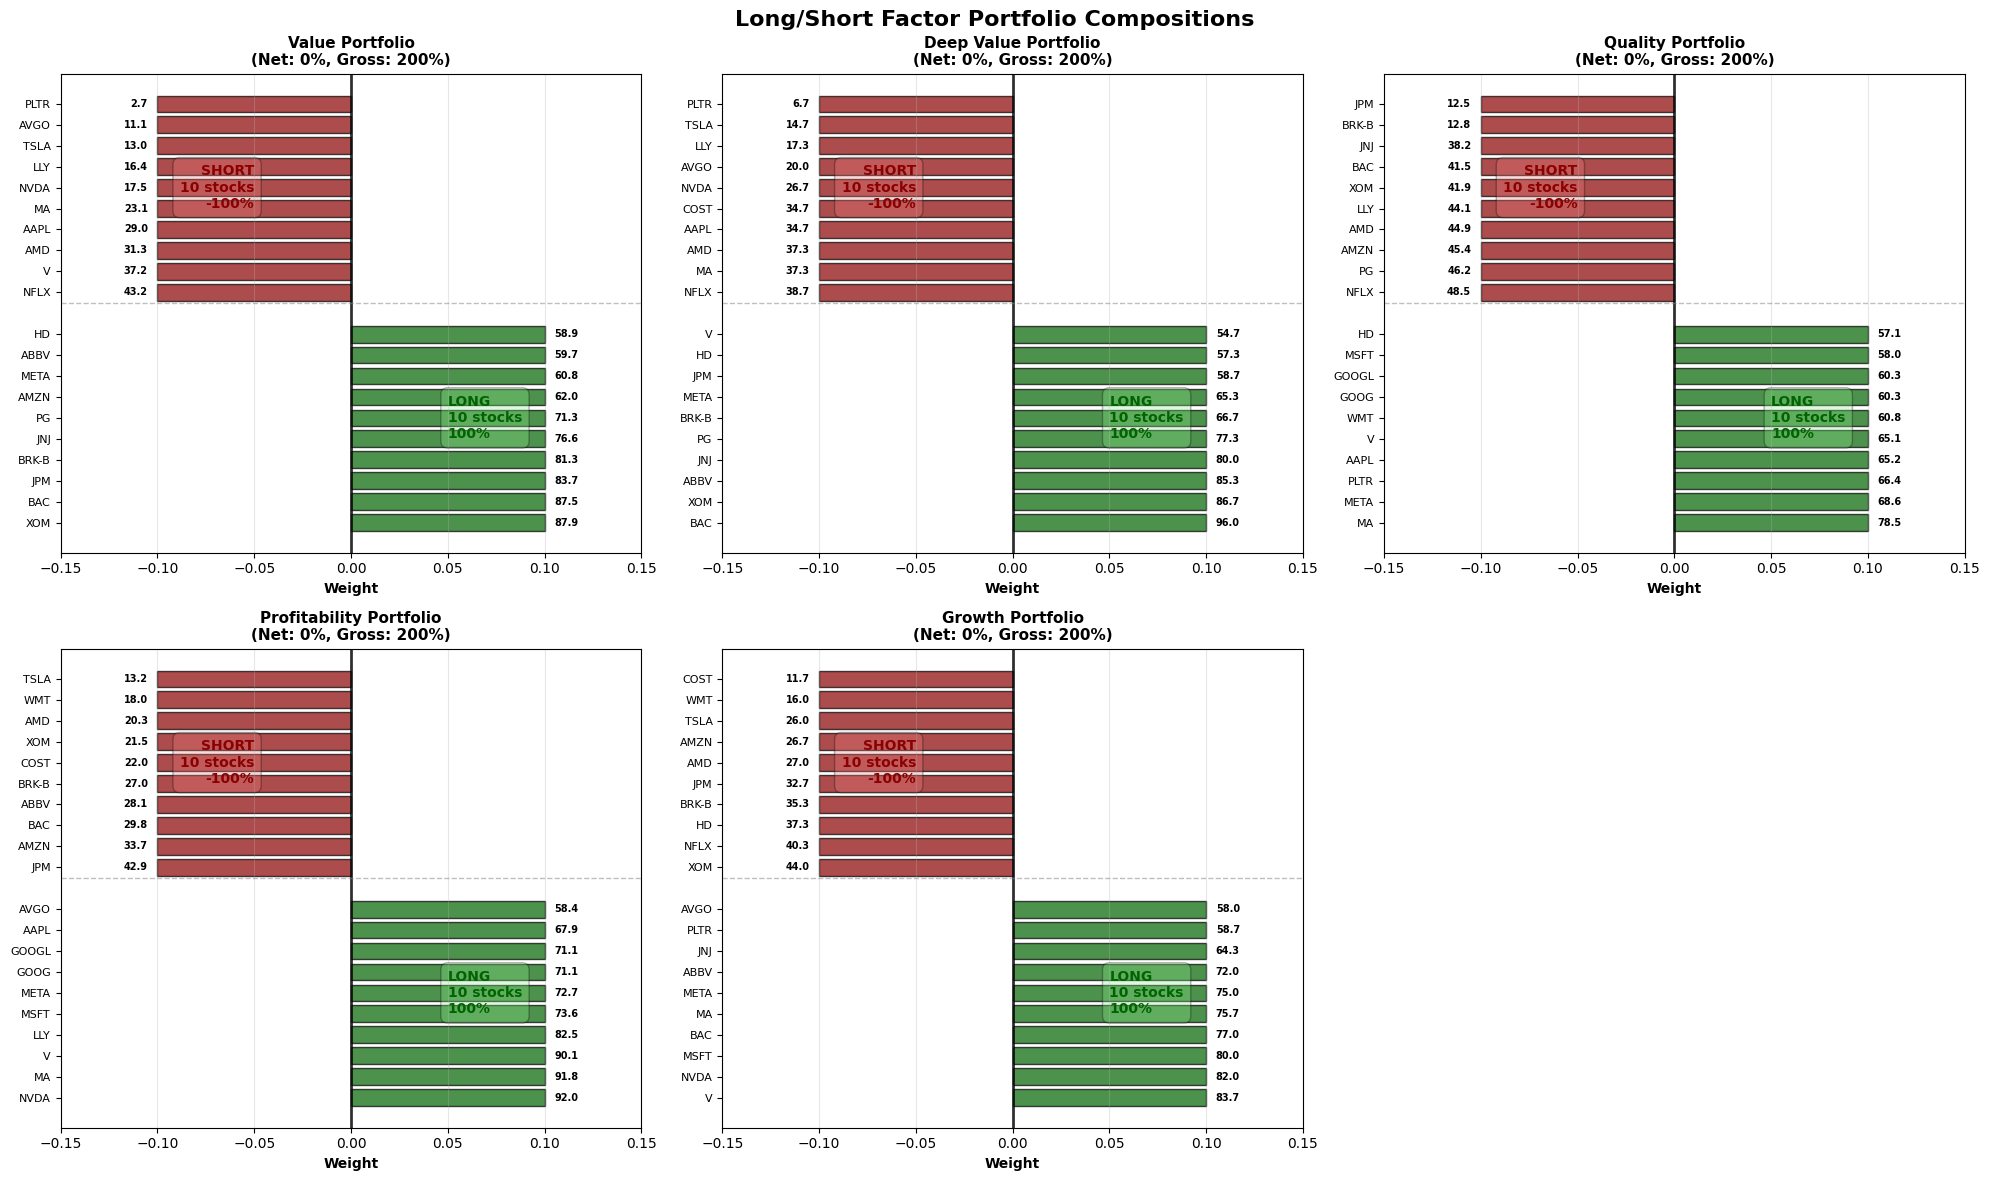

In [22]:
# Visualize long/short portfolios
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Long/Short Factor Portfolio Compositions', fontsize=16, fontweight='bold')

for idx, (portfolio_name, portfolio) in enumerate(long_short_portfolios.items()):
    if idx >= 5:  # We have 5 portfolios
        break
    
    ax = axes[idx // 3, idx % 3]
    
    # Separate long and short positions
    longs = portfolio[portfolio['Position'] == 'LONG'].copy()
    shorts = portfolio[portfolio['Position'] == 'SHORT'].copy()
    
    # Sort by factor score (descending for both)
    longs = longs.sort_values('Factor_Score', ascending=False)
    shorts = shorts.sort_values('Factor_Score', ascending=False)
    
    # Create positions for bars - LONG positions at top
    y_pos_long = np.arange(len(longs))
    y_pos_short = np.arange(len(shorts)) + len(longs) + 1  # Add gap
    
    # Plot long positions (green bars on right)
    bars_long = ax.barh(y_pos_long, longs['Weight'], color='darkgreen', alpha=0.7, 
                        edgecolor='black', linewidth=1)
    
    # Plot short positions (red bars on left)
    bars_short = ax.barh(y_pos_short, shorts['Weight'], color='darkred', alpha=0.7, 
                         edgecolor='black', linewidth=1)
    
    # Add ticker labels
    ax.set_yticks(list(y_pos_long) + list(y_pos_short))
    ax.set_yticklabels(list(longs.index) + list(shorts.index), fontsize=8)
    
    # Add factor score annotations
    for i, (ticker, row) in enumerate(longs.iterrows()):
        ax.text(row['Weight'] + 0.005, i, f"{row['Factor_Score']:.1f}", 
                va='center', fontsize=7, fontweight='bold')
    
    for i, (ticker, row) in enumerate(shorts.iterrows()):
        ax.text(row['Weight'] - 0.005, i + len(longs) + 1, f"{row['Factor_Score']:.1f}", 
                va='center', ha='right', fontsize=7, fontweight='bold')
    
    # Add reference line at 0
    ax.axvline(0, color='black', linewidth=2, alpha=0.8)
    
    # Add section labels
    ax.text(0.05, len(longs)/2, 'LONG\n10 stocks\n100%', 
            fontsize=10, fontweight='bold', color='darkgreen', 
            ha='left', va='center',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.3))
    
    ax.text(-0.05, len(longs) + 1 + len(shorts)/2, 'SHORT\n10 stocks\n-100%', 
            fontsize=10, fontweight='bold', color='darkred', 
            ha='right', va='center',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightcoral', alpha=0.3))
    
    # Formatting
    ax.set_xlabel('Weight', fontsize=10, fontweight='bold')
    ax.set_title(f'{portfolio_name} Portfolio\n(Net: 0%, Gross: 200%)', 
                fontsize=11, fontweight='bold')
    ax.set_xlim(-0.15, 0.15)
    ax.grid(axis='x', alpha=0.3)
    ax.axhline(len(longs) + 0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)

# Hide the 6th subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

In [23]:
# Cross-portfolio comparison: Sector exposures and concentration
print("=" * 120)
print("CROSS-PORTFOLIO ANALYSIS")
print("=" * 120)

# Create summary DataFrame
summary_data = []

for portfolio_name, portfolio in long_short_portfolios.items():
    longs = portfolio[portfolio['Position'] == 'LONG']
    shorts = portfolio[portfolio['Position'] == 'SHORT']
    
    # Calculate net sector exposures
    long_sectors = longs.groupby('Sector')['Weight'].sum()
    short_sectors = shorts.groupby('Sector')['Weight'].sum()
    
    # Combine for net exposure
    net_sectors = long_sectors.add(short_sectors, fill_value=0)
    
    # Find largest net long and short sector exposures
    max_long_sector = net_sectors.idxmax() if net_sectors.max() > 0 else 'None'
    max_long_exposure = net_sectors.max() if net_sectors.max() > 0 else 0
    
    max_short_sector = net_sectors.idxmin() if net_sectors.min() < 0 else 'None'
    max_short_exposure = net_sectors.min() if net_sectors.min() < 0 else 0
    
    # Calculate average factor scores
    avg_long_score = longs['Factor_Score'].mean()
    avg_short_score = shorts['Factor_Score'].mean()
    score_spread = avg_long_score - avg_short_score
    
    summary_data.append({
        'Portfolio': portfolio_name,
        'Holdings': len(portfolio),
        'Avg_Long_Score': avg_long_score,
        'Avg_Short_Score': avg_short_score,
        'Score_Spread': score_spread,
        'Max_Long_Sector': max_long_sector,
        'Max_Long_Exp': max_long_exposure,
        'Max_Short_Sector': max_short_sector,
        'Max_Short_Exp': max_short_exposure,
        'Num_Sectors_Long': len(long_sectors),
        'Num_Sectors_Short': len(short_sectors)
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.set_index('Portfolio')

print("\nPortfolio Summary Statistics:")
print("-" * 120)
display(summary_df)

# Detailed sector exposure table
print("\n" + "=" * 120)
print("NET SECTOR EXPOSURES BY PORTFOLIO")
print("=" * 120)

sector_exposure_data = []
for portfolio_name, portfolio in long_short_portfolios.items():
    sector_exposure = portfolio.groupby('Sector')['Weight'].sum().to_dict()
    sector_exposure['Portfolio'] = portfolio_name
    sector_exposure_data.append(sector_exposure)

sector_exposure_df = pd.DataFrame(sector_exposure_data).set_index('Portfolio').fillna(0)
sector_exposure_df = sector_exposure_df.sort_index(axis=1)

print("\nNet Sector Weights (Long + Short):")
print("-" * 120)
display(sector_exposure_df.style.format("{:.1%}").background_gradient(cmap='RdYlGn', axis=None, vmin=-0.5, vmax=0.5))

# Identify common holdings across portfolios
print("\n" + "=" * 120)
print("COMMON HOLDINGS ACROSS PORTFOLIOS")
print("=" * 120)

all_longs = set()
all_shorts = set()

for portfolio_name, portfolio in long_short_portfolios.items():
    longs = set(portfolio[portfolio['Position'] == 'LONG'].index)
    shorts = set(portfolio[portfolio['Position'] == 'SHORT'].index)
    all_longs.update(longs)
    all_shorts.update(shorts)

# Find stocks that appear in multiple long positions
long_counts = {}
for ticker in all_longs:
    count = sum([ticker in portfolio[portfolio['Position'] == 'LONG'].index 
                 for portfolio in long_short_portfolios.values()])
    if count > 1:
        long_counts[ticker] = count

# Find stocks that appear in multiple short positions
short_counts = {}
for ticker in all_shorts:
    count = sum([ticker in portfolio[portfolio['Position'] == 'SHORT'].index 
                 for portfolio in long_short_portfolios.values()])
    if count > 1:
        short_counts[ticker] = count

print(f"\nStocks appearing in multiple LONG portfolios:")
if long_counts:
    for ticker, count in sorted(long_counts.items(), key=lambda x: x[1], reverse=True):
        portfolios = [name for name, portfolio in long_short_portfolios.items() 
                     if ticker in portfolio[portfolio['Position'] == 'LONG'].index]
        print(f"  {ticker}: {count} portfolios ({', '.join(portfolios)})")
else:
    print("  None")

print(f"\nStocks appearing in multiple SHORT portfolios:")
if short_counts:
    for ticker, count in sorted(short_counts.items(), key=lambda x: x[1], reverse=True):
        portfolios = [name for name, portfolio in long_short_portfolios.items() 
                     if ticker in portfolio[portfolio['Position'] == 'SHORT'].index]
        print(f"  {ticker}: {count} portfolios ({', '.join(portfolios)})")
else:
    print("  None")

CROSS-PORTFOLIO ANALYSIS

Portfolio Summary Statistics:
------------------------------------------------------------------------------------------------------------------------


,Holdings,Avg_Long_Score,Avg_Short_Score,Score_Spread,Max_Long_Sector,Max_Long_Exp,Max_Short_Sector,Max_Short_Exp,Num_Sectors_Long,Num_Sectors_Short
Portfolio,,,,,,,,,,
Value,20,72.969697,22.448485,50.521212,Financial Services,0.1,Technology,-0.5,6,5
Deep Value,20,72.800000,26.800000,46.000000,Financial Services,0.3,Technology,-0.5,6,6
Quality,20,64.023030,37.601212,26.421818,Communication Services,0.2,Healthcare,-0.2,5,7
Profitability,20,77.123636,25.656364,51.467273,Communication Services,0.3,Consumer Cyclical,-0.2,4,6
Growth,20,72.633333,29.700000,42.933333,Technology,0.3,Consumer Cyclical,-0.3,4,6



NET SECTOR EXPOSURES BY PORTFOLIO

Net Sector Weights (Long + Short):
------------------------------------------------------------------------------------------------------------------------


,Communication Services,Consumer Cyclical,Consumer Defensive,Energy,Financial Services,Healthcare,Technology
Portfolio,,,,,,,
Value,0.0%,10.0%,10.0%,10.0%,10.0%,10.0%,-50.0%
Deep Value,0.0%,0.0%,0.0%,10.0%,30.0%,10.0%,-50.0%
Quality,20.0%,0.0%,0.0%,-10.0%,-10.0%,-20.0%,20.0%
Profitability,30.0%,-20.0%,-20.0%,-10.0%,-10.0%,0.0%,30.0%
Growth,0.0%,-30.0%,-20.0%,-10.0%,10.0%,20.0%,30.0%



COMMON HOLDINGS ACROSS PORTFOLIOS

Stocks appearing in multiple LONG portfolios:
  META: 5 portfolios (Value, Deep Value, Quality, Profitability, Growth)
  V: 4 portfolios (Deep Value, Quality, Profitability, Growth)
  BAC: 3 portfolios (Value, Deep Value, Growth)
  MA: 3 portfolios (Quality, Profitability, Growth)
  ABBV: 3 portfolios (Value, Deep Value, Growth)
  MSFT: 3 portfolios (Quality, Profitability, Growth)
  JNJ: 3 portfolios (Value, Deep Value, Growth)
  HD: 3 portfolios (Value, Deep Value, Quality)
  GOOGL: 2 portfolios (Quality, Profitability)
  AAPL: 2 portfolios (Quality, Profitability)
  PG: 2 portfolios (Value, Deep Value)
  XOM: 2 portfolios (Value, Deep Value)
  JPM: 2 portfolios (Value, Deep Value)
  NVDA: 2 portfolios (Profitability, Growth)
  GOOG: 2 portfolios (Quality, Profitability)
  BRK-B: 2 portfolios (Value, Deep Value)
  PLTR: 2 portfolios (Quality, Growth)
  AVGO: 2 portfolios (Profitability, Growth)

Stocks appearing in multiple SHORT portfolios:
  AMD:

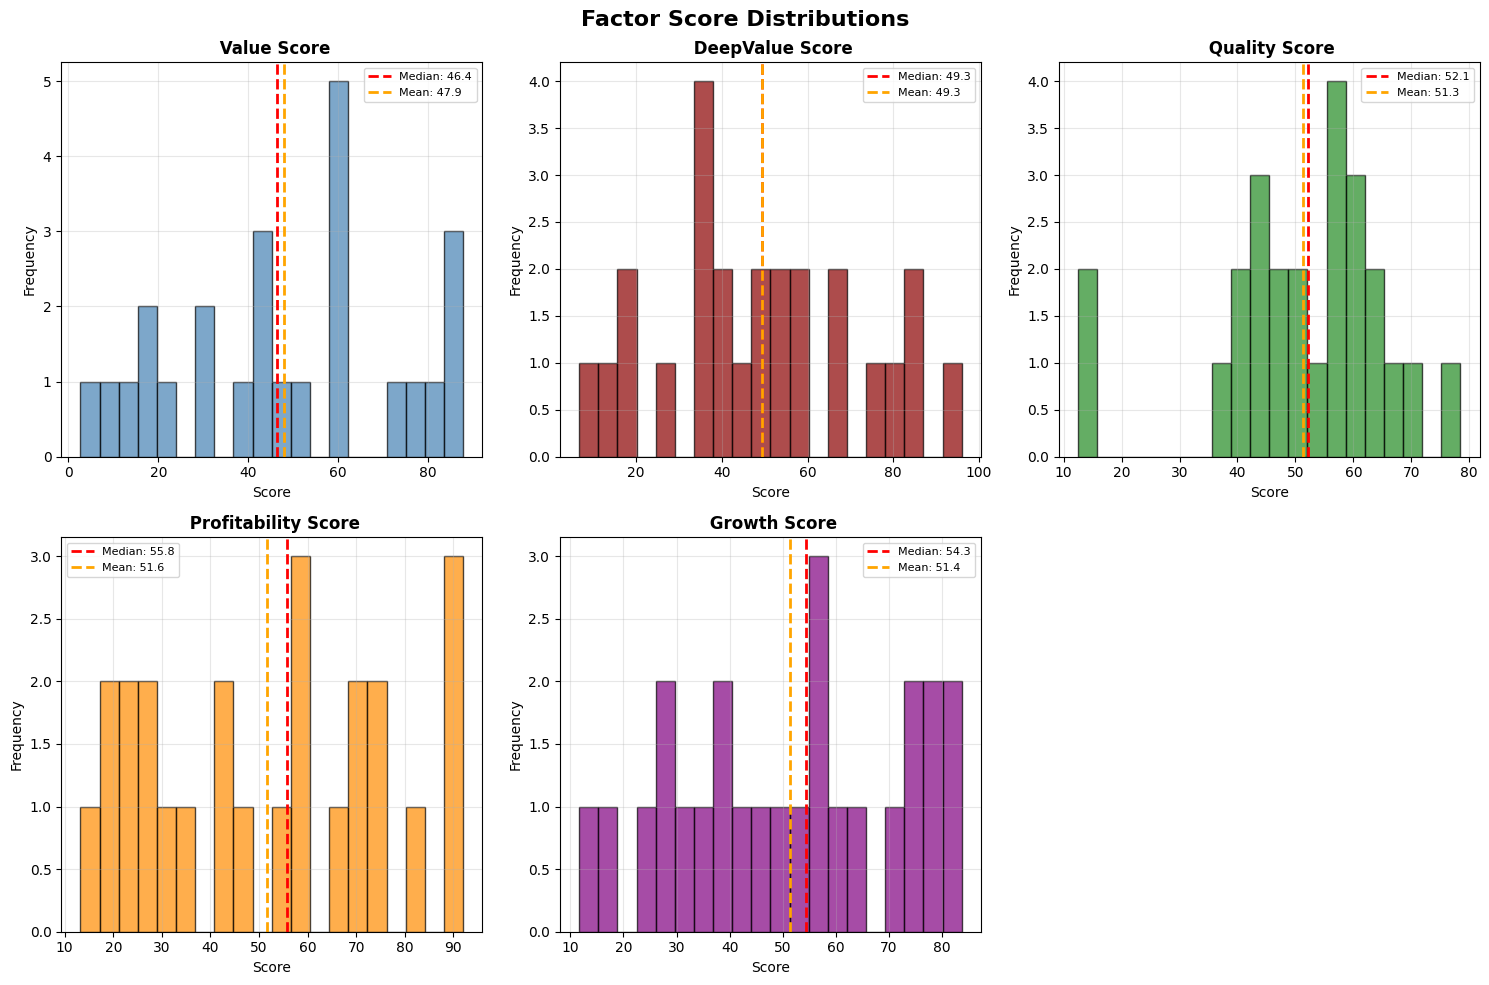

In [24]:
# Visualize factor score distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Factor Score Distributions', fontsize=16, fontweight='bold')

factors = ['_Value_Score', '_DeepValue_Score', '_Quality_Score', '_Profitability_Score', '_Growth_Score']
colors = ['steelblue', 'darkred', 'forestgreen', 'darkorange', 'purple']

for i, (factor, color) in enumerate(zip(factors, colors)):
    ax = axes[i // 3, i % 3]
    
    # Histogram
    ax.hist(df_ltm[factor].dropna(), bins=20, alpha=0.7, color=color, edgecolor='black')
    ax.axvline(df_ltm[factor].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {df_ltm[factor].median():.1f}')
    ax.axvline(df_ltm[factor].mean(), color='orange', linestyle='--', linewidth=2, label=f'Mean: {df_ltm[factor].mean():.1f}')
    
    ax.set_title(factor.replace('_', ' '), fontsize=12, fontweight='bold')
    ax.set_xlabel('Score', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

# Hide the 6th subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

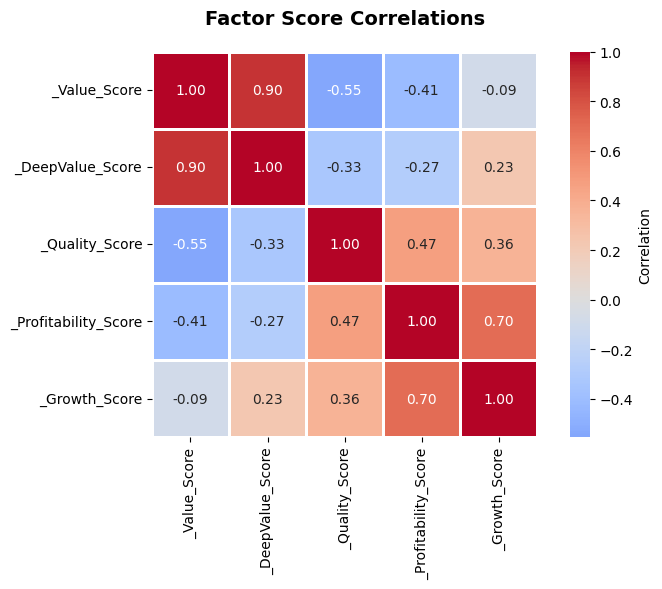


Factor Correlation Insights:
Quality vs Profitability: 0.47
Value vs Quality: -0.55
Value vs Deep Value: 0.90
Growth vs Quality: 0.36


In [25]:
# Factor correlation heatmap
factor_corr = df_ltm[['_Value_Score', '_DeepValue_Score', '_Quality_Score', 
                              '_Profitability_Score', '_Growth_Score']].corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(factor_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={'label': 'Correlation'}, ax=ax)

ax.set_title('Factor Score Correlations', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nFactor Correlation Insights:")
print("=" * 80)
print(f"Quality vs Profitability: {factor_corr.loc['_Quality_Score', '_Profitability_Score']:.2f}")
print(f"Value vs Quality: {factor_corr.loc['_Value_Score', '_Quality_Score']:.2f}")
print(f"Value vs Deep Value: {factor_corr.loc['_Value_Score', '_DeepValue_Score']:.2f}")
print(f"Growth vs Quality: {factor_corr.loc['_Growth_Score', '_Quality_Score']:.2f}")

## Sector P/E Contribution Analysis

This analysis calculates how each sector contributes to the overall index P/E ratio using a **bottom-up earnings approach**:

1. **Sector Earnings Calculation**: For each stock, we calculate total earnings as `LTM EPS × Shares Outstanding`
2. **Sector Aggregation**: Sum earnings, market capitalization, and shares outstanding across all stocks in each sector
3. **Sector Metrics**:
   - **Sector P/E**: `Sector Market Cap / Sector Earnings` (inverse of earnings yield)
   - **Sector Earnings Yield**: `Sector Earnings / Sector Market Cap` (inverse of P/E)
   - **Sector EPS**: `Sector Earnings / Sector Shares Outstanding` (aggregate earnings per share)
4. **Index P/E**: Calculate as `Total Index Market Cap / Total Index Earnings`
5. **P/E Contribution**: Calculate how much each sector contributes to the index P/E:
   ```
   PE_Contribution = (Sector_Earnings / Index_Earnings) × Index_PE
   ```


In [26]:
fa.sector_pe_contribution(official_pe=None, df=df_fun)

The index P/E ratio is: 32.81


,Sector,Count,Sector_Weight,Sector_PE,Sector_Earnings_Yield,Sector_EPS,Sector_Earnings_Pct,PE_Contribution,PE_Contribution_Pct
0,Communication Services,4,14.18493,29.254326,3.418298,10.686134,30.258526,9.926813,30.258526
1,Consumer Cyclical,3,10.54109,44.456237,2.249403,6.327915,8.787156,2.882773,8.787156
2,Consumer Defensive,3,3.40658,36.529002,2.737551,4.185588,4.120400,1.351766,4.120400
3,Energy,1,1.36658,16.977625,5.890106,6.830000,2.673400,0.877054,2.673400
4,Financial Services,5,8.67674,19.471141,5.135806,11.454913,16.209565,5.317817,16.209565
5,Healthcare,3,4.76698,27.692128,3.611135,12.946131,5.966425,1.957385,5.966425
6,Technology,6,40.60847,41.522762,2.408318,6.317779,31.984527,10.493056,31.984527
7,TOTAL,25,83.55137,NaN,3.048161,7.977910,100.000000,32.806664,100.000000


## Clustering

In [27]:
# Prepare data for clustering analysis
# Select key fundamental metrics for clustering
cluster_metrics = [
    '_ROE', '_ROIC', '_NetProfitMargin', '_GrossProfitMargin', '_OperatingProfitMargin',
    '_PriceToEarnings', '_PriceToBook', '_PriceToSales', '_EV_to_EBITDA',
    '_FCF_Yield', '_FCF_Margin', '_DebtToEquity', '_CurrentRatio', '_AssetTurnover',
    '_ROA', '_CashFlow_Quality', '_FCF_to_NetIncome'
]

# Filter to metrics that exist and have sufficient data
available_metrics = [m for m in cluster_metrics if m in df_ltm.columns]
print(f"Using {len(available_metrics)} metrics for clustering:")
print(", ".join(available_metrics))

# Create clustering dataset
df_clustering = df_ltm[available_metrics].copy()

# Remove rows with too many missing values
df_clustering = df_clustering.dropna(thresh=len(available_metrics) * 0.7)  # At least 70% non-null

# Fill remaining NaN with median
df_clustering = df_clustering.fillna(df_clustering.median())

print(f"\nClustering dataset shape: {df_clustering.shape}")
print(f"Companies included: {len(df_clustering)}")

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clustering)

# Perform K-means clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Perform PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Create result dataframe
df_cluster = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'Cluster': cluster_labels
}, index=df_clustering.index)

print(f"\nPCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained (2 components): {pca.explained_variance_ratio_.sum():.2%}")

# Display cluster sizes
print("\nCluster Sizes:")
for i in range(n_clusters):
    cluster_size = (df_cluster['Cluster'] == i).sum()
    print(f"  Cluster {i}: {cluster_size} companies ({cluster_size/len(df_cluster)*100:.1f}%)")

Using 17 metrics for clustering:
_ROE, _ROIC, _NetProfitMargin, _GrossProfitMargin, _OperatingProfitMargin, _PriceToEarnings, _PriceToBook, _PriceToSales, _EV_to_EBITDA, _FCF_Yield, _FCF_Margin, _DebtToEquity, _CurrentRatio, _AssetTurnover, _ROA, _CashFlow_Quality, _FCF_to_NetIncome

Clustering dataset shape: (25, 17)
Companies included: 25

PCA explained variance ratio: [0.32595678 0.21929305]
Total variance explained (2 components): 54.52%

Cluster Sizes:
  Cluster 0: 11 companies (44.0%)
  Cluster 1: 3 companies (12.0%)
  Cluster 2: 1 companies (4.0%)
  Cluster 3: 9 companies (36.0%)
  Cluster 4: 1 companies (4.0%)

PCA explained variance ratio: [0.32595678 0.21929305]
Total variance explained (2 components): 54.52%

Cluster Sizes:
  Cluster 0: 11 companies (44.0%)
  Cluster 1: 3 companies (12.0%)
  Cluster 2: 1 companies (4.0%)
  Cluster 3: 9 companies (36.0%)
  Cluster 4: 1 companies (4.0%)


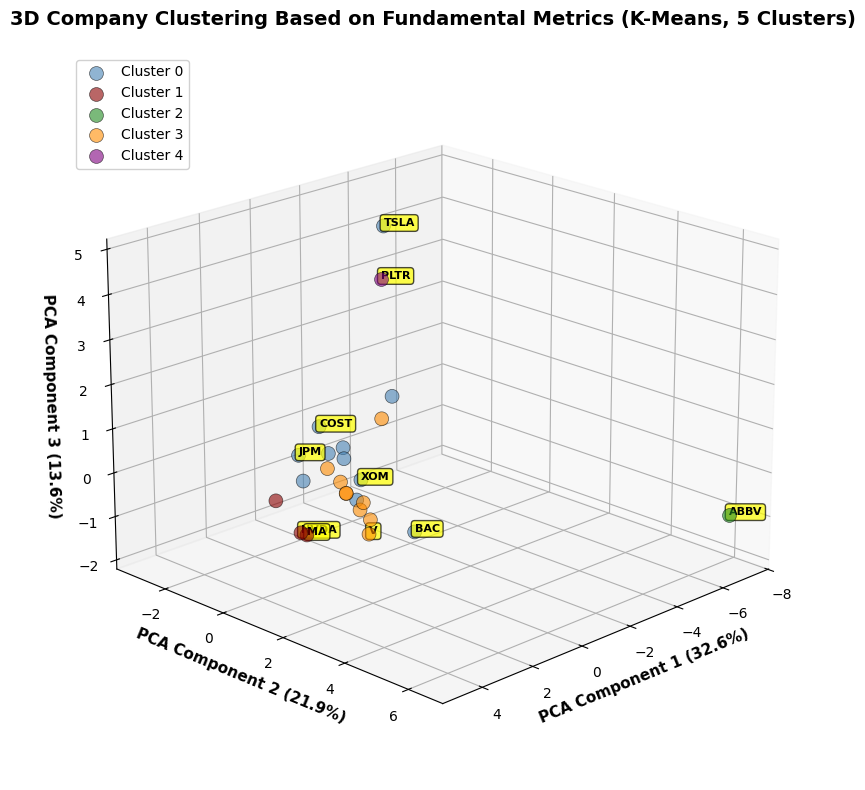


3D PCA explained variance ratio: [0.32595678 0.21929305 0.13550916]
Total variance explained (3 components): 68.08%


In [28]:
# Create 3D scatter plot with PCA
from mpl_toolkits.mplot3d import Axes3D

# Perform PCA for 3D visualization
pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_scaled)

df_cluster['PCA3'] = X_pca_3d[:, 2]

# Create 3D scatter plot
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d')

# Define colors for each cluster
colors = ['steelblue', 'darkred', 'forestgreen', 'darkorange', 'purple']
cluster_names = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']

# Plot each cluster
for cluster_id in range(5):
    cluster_data = df_cluster[df_cluster['Cluster'] == cluster_id]
    ax.scatter(cluster_data['PCA1'], cluster_data['PCA2'], cluster_data['PCA3'],
               c=colors[cluster_id], label=cluster_names[cluster_id], 
               alpha=0.6, s=100, edgecolors='black', linewidth=0.5)

# Annotate some notable points (top and bottom on each PCA axis)
n_annotations = 2  # Annotate top 2 extreme points on each axis for clarity

# Find extreme points
top_pca1 = df_cluster.nlargest(n_annotations, 'PCA1').index
bottom_pca1 = df_cluster.nsmallest(n_annotations, 'PCA1').index
top_pca2 = df_cluster.nlargest(n_annotations, 'PCA2').index
bottom_pca2 = df_cluster.nsmallest(n_annotations, 'PCA2').index
top_pca3 = df_cluster.nlargest(n_annotations, 'PCA3').index
bottom_pca3 = df_cluster.nsmallest(n_annotations, 'PCA3').index

# Combine unique tickers to annotate
tickers_to_annotate_3d = set(list(top_pca1) + list(bottom_pca1) + list(top_pca2) + 
                               list(bottom_pca2) + list(top_pca3) + list(bottom_pca3))

# Add annotations
for ticker in tickers_to_annotate_3d:
    x = df_cluster.loc[ticker, 'PCA1']
    y = df_cluster.loc[ticker, 'PCA2']
    z = df_cluster.loc[ticker, 'PCA3']
    ax.text(x, y, z, ticker, fontsize=8, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7, edgecolor='black'))

# Labels and title
ax.set_xlabel(f'PCA Component 1 ({pca_3d.explained_variance_ratio_[0]:.1%})', fontsize=11, fontweight='bold')
ax.set_ylabel(f'PCA Component 2 ({pca_3d.explained_variance_ratio_[1]:.1%})', fontsize=11, fontweight='bold')
ax.set_zlabel(f'PCA Component 3 ({pca_3d.explained_variance_ratio_[2]:.1%})', fontsize=11, fontweight='bold')
ax.set_title('3D Company Clustering Based on Fundamental Metrics (K-Means, 5 Clusters)', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3)

# Set viewing angle
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

print(f"\n3D PCA explained variance ratio: {pca_3d.explained_variance_ratio_}")
print(f"Total variance explained (3 components): {pca_3d.explained_variance_ratio_.sum():.2%}")

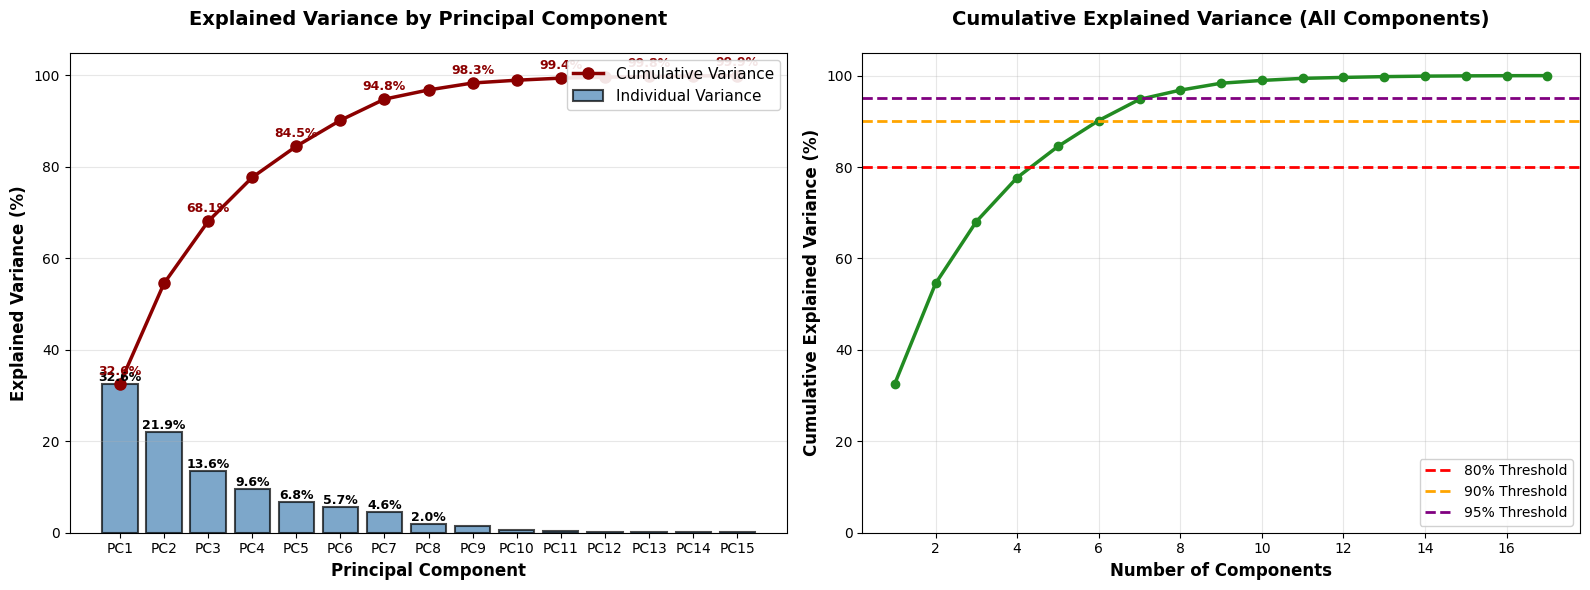


PCA VARIANCE SUMMARY
First 3 components explain: 68.08% of variance
First 5 components explain: 84.51% of variance
First 10 components explain: 98.95% of variance

Components needed for 80% variance: 5
Components needed for 90% variance: 6
Components needed for 95% variance: 8

Total number of components: 17


In [29]:
# Create bar chart showing cumulative explained variance by principal component
# Perform full PCA to show all components
pca_full = PCA(random_state=42)
pca_full.fit(X_scaled)

# Calculate cumulative explained variance
explained_var = pca_full.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Create the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Individual and Cumulative Explained Variance
n_components = min(15, len(explained_var))  # Show first 15 components
x_pos = np.arange(1, n_components + 1)

# Bar chart for individual variance
bars = ax1.bar(x_pos, explained_var[:n_components] * 100, 
               alpha=0.7, color='steelblue', edgecolor='black', linewidth=1.5,
               label='Individual Variance')

# Line chart for cumulative variance
line = ax1.plot(x_pos, cumulative_var[:n_components] * 100, 
                color='darkred', marker='o', linewidth=2.5, markersize=8,
                label='Cumulative Variance')

# Formatting
ax1.set_xlabel('Principal Component', fontsize=12, fontweight='bold')
ax1.set_ylabel('Explained Variance (%)', fontsize=12, fontweight='bold')
ax1.set_title('Explained Variance by Principal Component', fontsize=14, fontweight='bold', pad=20)
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f'PC{i}' for i in x_pos])
ax1.legend(fontsize=11, loc='upper right', framealpha=0.9)
ax1.grid(True, alpha=0.3, axis='y')

# Add percentage labels on top of bars
for i, (bar, var) in enumerate(zip(bars, explained_var[:n_components])):
    if var * 100 > 2:  # Only label bars > 2%
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{var*100:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Add cumulative percentage labels
for i, cum_var in enumerate(cumulative_var[:n_components:2]):  # Every other point
    ax1.text(x_pos[i*2], cum_var * 100 + 2, f'{cum_var*100:.1f}%', 
            ha='center', fontsize=9, color='darkred', fontweight='bold')

# Plot 2: Cumulative Explained Variance (Full range)
ax2.plot(range(1, len(cumulative_var) + 1), cumulative_var * 100, 
         color='forestgreen', marker='o', linewidth=2.5, markersize=6)
ax2.axhline(y=80, color='red', linestyle='--', linewidth=2, label='80% Threshold')
ax2.axhline(y=90, color='orange', linestyle='--', linewidth=2, label='90% Threshold')
ax2.axhline(y=95, color='purple', linestyle='--', linewidth=2, label='95% Threshold')

# Find components needed for thresholds
comp_80 = np.argmax(cumulative_var >= 0.80) + 1
comp_90 = np.argmax(cumulative_var >= 0.90) + 1
comp_95 = np.argmax(cumulative_var >= 0.95) + 1

ax2.set_xlabel('Number of Components', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cumulative Explained Variance (%)', fontsize=12, fontweight='bold')
ax2.set_title('Cumulative Explained Variance (All Components)', fontsize=14, fontweight='bold', pad=20)
ax2.legend(fontsize=10, loc='lower right', framealpha=0.9)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 105])

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "=" * 80)
print("PCA VARIANCE SUMMARY")
print("=" * 80)
print(f"First 3 components explain: {cumulative_var[2]*100:.2f}% of variance")
print(f"First 5 components explain: {cumulative_var[4]*100:.2f}% of variance")
print(f"First 10 components explain: {cumulative_var[9]*100:.2f}% of variance")
print(f"\nComponents needed for 80% variance: {comp_80}")
print(f"Components needed for 90% variance: {comp_90}")
print(f"Components needed for 95% variance: {comp_95}")
print(f"\nTotal number of components: {len(explained_var)}")

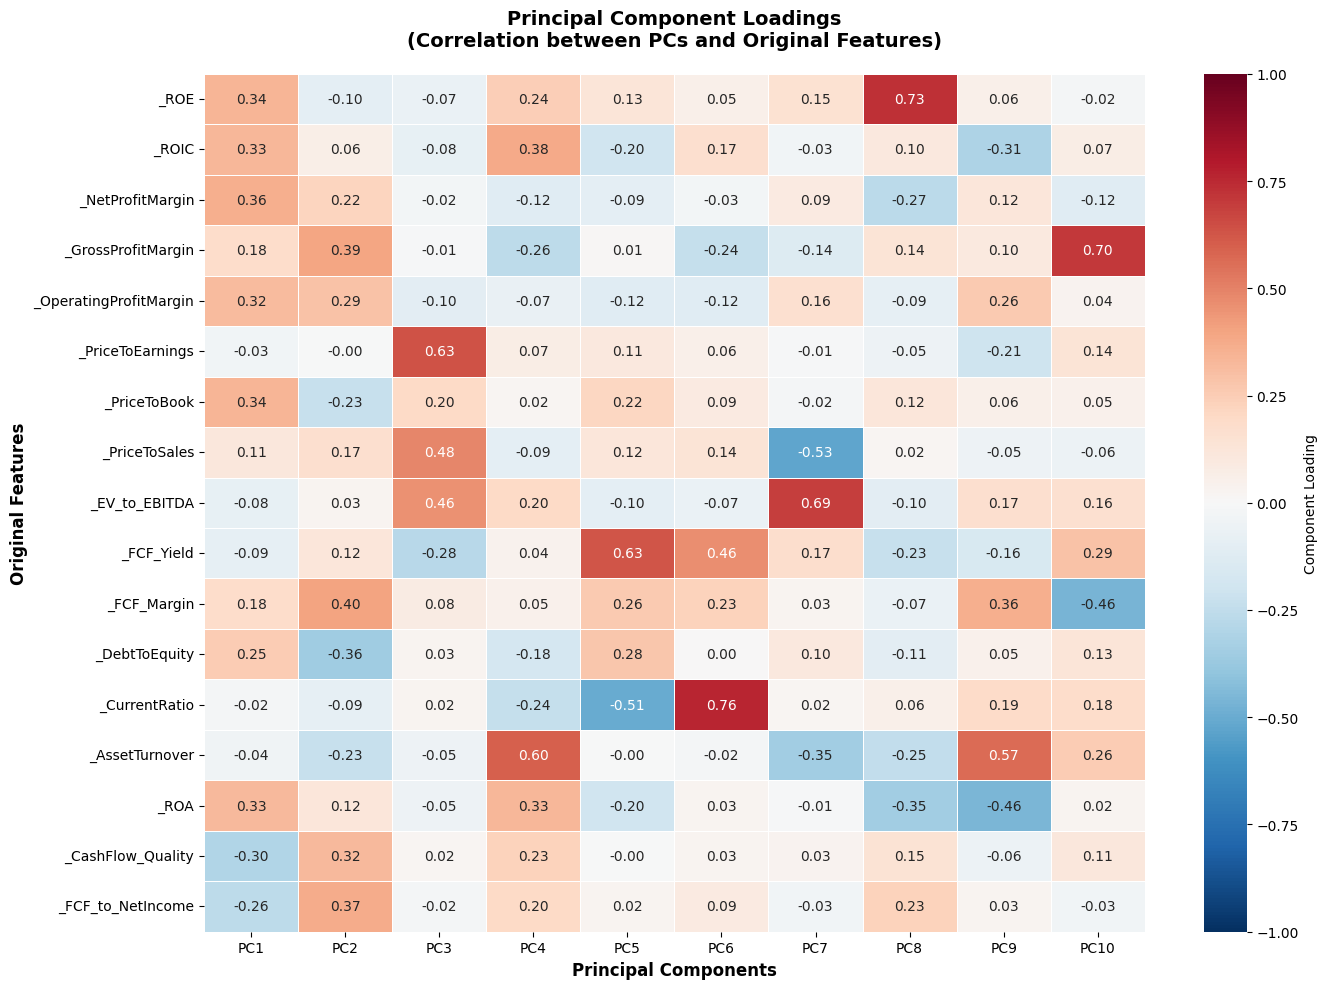


TOP 3 FEATURES BY ABSOLUTE LOADING FOR EACH PRINCIPAL COMPONENT

PC1 (explains 32.6% variance):
  _NetProfitMargin: 0.364 (positive)
  _PriceToBook: 0.338 (positive)
  _ROE: 0.337 (positive)

PC2 (explains 21.9% variance):
  _FCF_Margin: 0.402 (positive)
  _GrossProfitMargin: 0.391 (positive)
  _FCF_to_NetIncome: 0.369 (positive)

PC3 (explains 13.6% variance):
  _PriceToEarnings: 0.634 (positive)
  _PriceToSales: 0.485 (positive)
  _EV_to_EBITDA: 0.456 (positive)

PC4 (explains 9.6% variance):
  _AssetTurnover: 0.599 (positive)
  _ROIC: 0.378 (positive)
  _ROA: 0.335 (positive)

PC5 (explains 6.8% variance):
  _FCF_Yield: 0.630 (positive)
  _CurrentRatio: -0.506 (negative)
  _DebtToEquity: 0.280 (positive)


In [30]:
# Create heatmap showing correlation between principal components and original features
# Get the component loadings (correlation between PCs and original features)
n_components_to_show = min(10, len(pca_full.components_))

# Create DataFrame of component loadings
component_loadings = pd.DataFrame(
    pca_full.components_[:n_components_to_show].T,
    columns=[f'PC{i+1}' for i in range(n_components_to_show)],
    index=available_metrics
)

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(component_loadings, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            cbar_kws={'label': 'Component Loading'}, linewidths=0.5, ax=ax,
            vmin=-1, vmax=1)

ax.set_title('Principal Component Loadings\n(Correlation between PCs and Original Features)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Principal Components', fontsize=12, fontweight='bold')
ax.set_ylabel('Original Features', fontsize=12, fontweight='bold')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

# Print top 3 features for each PC
print("\n" + "=" * 80)
print("TOP 3 FEATURES BY ABSOLUTE LOADING FOR EACH PRINCIPAL COMPONENT")
print("=" * 80)
for pc in component_loadings.columns[:5]:  # Show first 5 PCs
    top_features = component_loadings[pc].abs().nlargest(3)
    print(f"\n{pc} (explains {pca_full.explained_variance_ratio_[int(pc[2:])-1]*100:.1f}% variance):")
    for feature, loading in top_features.items():
        actual_loading = component_loadings.loc[feature, pc]
        direction = "positive" if actual_loading > 0 else "negative"
        print(f"  {feature}: {actual_loading:.3f} ({direction})")


# Corporate Earnings

In [31]:
class Earnings:
    """
    Fetch and process earnings data from EODHD API.
    
    Examples
    --------
    >>> earnings = Earnings(api_key=API_KEY)
    >>> df = earnings.fetch('AAPL')
    >>> df = earnings.fetch_multiple(['AAPL', 'GOOGL', 'MSFT'])
    >>> history = earnings.get_earnings_history('AAPL')
    >>> surprise = earnings.calculate_surprise('AAPL')
    """
    
    def __init__(self, api_key: str):
        """
        Initialize Earnings fetcher.
        
        Parameters
        ----------
        api_key : str
            EODHD API key
        """
        self.api_key = api_key
        self.base_url = 'https://eodhd.com/api/fundamentals'
        self._cache = {}
    
    def fetch(self, ticker: str, use_cache: bool = True) -> pd.DataFrame:
        """
        Fetch earnings data for a single ticker.
        
        Parameters
        ----------
        ticker : str
            Stock ticker symbol (e.g., 'AAPL', 'GOOGL.US')
        use_cache : bool
            Use cached data if available
            
        Returns
        -------
        pd.DataFrame
            Earnings data with columns: date, epsActual, epsEstimate, 
            epsDifference, surprisePercent, ticker
        """
        ticker = ticker.upper()
        
        # Check cache
        if use_cache and ticker in self._cache:
            return self._cache[ticker].copy()
        
        # Ensure ticker has exchange suffix
        if '.' not in ticker:
            ticker = f'{ticker}' # .US, .INDX for securities
        
        url = f'{self.base_url}/{ticker}?api_token={self.api_key}&fmt=json&filter=Earnings'
        
        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()
            
            data = response.json()
            
            if not data:
                print(f"No earnings data available for {ticker}")
                return pd.DataFrame()
            
            # Handle both dict and list responses
            if isinstance(data, dict):
                if 'History' in data:
                    earnings_data = data['History']
                elif 'Trend' in data:
                    # Some tickers return both History and Trend
                    earnings_data = data['History']
                else:
                    earnings_data = data
            else:
                earnings_data = data
            
            df = pd.DataFrame(earnings_data)
            
            if df.empty:
                print(f"No earnings history found for {ticker}")
                return pd.DataFrame()
            
            # Clean and process data
            df['ticker'] = ticker.split('.')[0]  # Remove exchange suffix for display
            
            # Convert date to datetime
            if 'date' in df.columns:
                df['date'] = pd.to_datetime(df['date'])
                df = df.sort_values('date', ascending=False)
            
            # Calculate surprise percentage if not present
            if 'epsActual' in df.columns and 'epsEstimate' in df.columns:
                if 'surprisePercent' not in df.columns:
                    df['surprisePercent'] = ((df['epsActual'] - df['epsEstimate']) / 
                                            df['epsEstimate'].abs() * 100)
            
            # Cache result
            self._cache[ticker.split('.')[0]] = df.copy()
            
            return df
            
        except requests.exceptions.RequestException as e:
            print(f"Error fetching data for {ticker}: {e}")
            return pd.DataFrame()
        except Exception as e:
            print(f"Unexpected error for {ticker}: {e}")
            return pd.DataFrame()
    
    def fetch_multiple(self, tickers: list, delay: float = 0.1) -> pd.DataFrame:
        """
        Fetch earnings data for multiple tickers.
        
        Parameters
        ----------
        tickers : list
            List of ticker symbols
        delay : float
            Delay between requests in seconds (to respect API limits)
            
        Returns
        -------
        pd.DataFrame
            Combined earnings data for all tickers
        """
        all_data = []
        
        for ticker in tickers:
            df = self.fetch(ticker)
            if not df.empty:
                all_data.append(df)
            time.sleep(delay)  # Rate limiting
        
        if all_data:
            combined = pd.concat(all_data, ignore_index=True)
            if 'date' in combined.columns:
                combined = combined.sort_values(['ticker', 'date'], ascending=[True, False])
            return combined
        else:
            return pd.DataFrame()
    
    
    def get_latest_earnings(self, ticker: str) -> dict:
        """
        Get most recent earnings report.
        
        Parameters
        ----------
        ticker : str
            Stock ticker symbol
            
        Returns
        -------
        dict
            Latest earnings data
        """
        df = self.fetch(ticker)
        
        if df.empty:
            return {}
        
        latest = df.iloc[0].to_dict()
        return latest
    
    def clear_cache(self):
        """Clear cached earnings data."""
        self._cache = {}


In [32]:
# Initialize once
earnings = Earnings(api_key=API_KEY)

# Single ticker
df = earnings.fetch('NVDA.US')
df

,2026-01-31,2025-10-31,2025-07-31,2025-04-30,2025-01-31,2024-10-31,2024-07-31,2024-04-30,2024-01-31,2023-10-31,...,2001-04-30,2001-01-31,2000-10-31,2000-07-31,2000-04-30,2000-01-31,1999-10-31,1999-07-31,1999-04-30,ticker
reportDate,2026-02-12,2025-11-19,2025-08-27,2025-05-28,2025-02-26,2024-11-20,2024-08-28,2024-05-22,2024-02-21,2023-11-21,...,2001-05-22,2001-02-15,2000-11-09,2000-08-21,2000-05-16,2000-02-15,1999-11-18,1999-08-18,1999-05-18,NVDA
date,2026-01-31,2025-10-31,2025-07-31,2025-04-30,2025-01-31,2024-10-31,2024-07-31,2024-04-30,2024-01-31,2023-10-31,...,2001-04-30,2001-01-31,2000-10-31,2000-07-31,2000-04-30,2000-01-31,1999-10-31,1999-07-31,1999-04-30,NVDA
beforeAfterMarket,None,AfterMarket,AfterMarket,AfterMarket,AfterMarket,AfterMarket,AfterMarket,AfterMarket,AfterMarket,AfterMarket,...,None,None,None,None,None,None,None,None,None,NVDA
currency,None,None,None,USD,USD,USD,USD,USD,USD,USD,...,USD,USD,USD,USD,USD,USD,USD,USD,USD,NVDA
epsActual,0,1.3,1.05,0.81,0.89,0.81,0.68,0.612,0.516,0.402,...,0.002,0.001,0.001,0.001,0.001,0.001,0.001,0.002,0.002,NVDA
epsEstimate,1.43,1.24,1.01,0.75,0.85,0.75,0.63,0.559,0.461,0.336,...,0.002,0.002,0.001,0.001,0.001,0.001,0.002,0.002,0.001,NVDA
epsDifference,-1.43,0.06,0.04,0.06,0.04,0.06,0.05,0.053,0.055,0.066,...,0,-0.001,0,0,0,0,-0.001,0,0.001,NVDA
surprisePercent,-100,4.8387,3.9604,8,4.7059,8,7.9365,9.4812,11.9306,19.6429,...,0,-50,0,0,0,0,-50,0,100,NVDA


In [33]:
multi = earnings.fetch_multiple(['AAPL', 'GOOGL', 'MSFT'], delay=0.1)
multi

,2026-03-31,2025-12-31,2025-09-30,2025-06-30,2025-03-31,2024-12-31,2024-09-30,2024-06-30,2024-03-31,2023-12-31,...,1995-09-30,1995-06-30,1995-03-31,1994-12-31,1994-09-30,1994-06-30,1994-03-31,1993-12-31,ticker,1993-09-30
0,2026-04-29,2026-01-28,2025-10-30,2025-07-31,2025-05-01,2025-01-30,2024-10-31,2024-08-01,2024-05-02,2024-02-01,...,1995-10-18,1995-07-20,1995-04-20,1995-01-19,1994-10-17,1994-06-30,1994-03-31,1993-12-31,AAPL,NaN
1,2026-03-31,2025-12-31,2025-09-30,2025-06-30,2025-03-31,2024-12-31,2024-09-30,2024-06-30,2024-03-31,2023-12-31,...,1995-09-30,1995-06-30,1995-03-31,1994-12-31,1994-09-30,1994-06-30,1994-03-31,1993-12-31,AAPL,NaN
2,BeforeMarket,AfterMarket,AfterMarket,AfterMarket,AfterMarket,AfterMarket,AfterMarket,AfterMarket,AfterMarket,AfterMarket,...,None,None,None,None,None,None,None,None,AAPL,NaN
3,None,USD,USD,USD,USD,USD,USD,USD,USD,USD,...,USD,USD,USD,USD,USD,USD,USD,USD,AAPL,NaN
4,None,None,1.85,1.57,1.65,2.4,0.97,1.4,1.53,2.18,...,0.02,0.03,0.02,0.05,0.03,0.0104,0.0104,0.0031,AAPL,NaN
5,None,2.67,1.76,1.43,1.62,2.34,0.95,1.34,1.5,2.11,...,0.02,0.03,0.03,0.04,0.03,None,None,None,AAPL,NaN
6,0,0,0.09,0.14,0.03,0.06,0.02,0.06,0.03,0.07,...,0,0,-0.01,0.01,0,0,0,0,AAPL,NaN
7,None,None,5.1136,9.7902,1.8519,2.5641,2.1053,4.4776,2,3.3175,...,0,0,-33.3333,25,0,None,None,None,AAPL,NaN
8,NaN,2026-02-03,2025-10-29,2025-07-23,2025-04-24,2025-02-04,2024-10-29,2024-07-23,2024-04-25,2024-01-30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GOOGL,NaN
9,NaN,2025-12-31,2025-09-30,2025-06-30,2025-03-31,2024-12-31,2024-09-30,2024-06-30,2024-03-31,2023-12-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GOOGL,NaN


In [34]:
# Latest report only
latest = earnings.get_latest_earnings('AAPL')
latest

{'2026-03-31': '2026-04-29',
 '2025-12-31': '2026-01-28',
 '2025-09-30': '2025-10-30',
 '2025-06-30': '2025-07-31',
 '2025-03-31': '2025-05-01',
 '2024-12-31': '2025-01-30',
 '2024-09-30': '2024-10-31',
 '2024-06-30': '2024-08-01',
 '2024-03-31': '2024-05-02',
 '2023-12-31': '2024-02-01',
 '2023-09-30': '2023-11-02',
 '2023-06-30': '2023-08-03',
 '2023-03-31': '2023-05-04',
 '2022-12-31': '2023-02-02',
 '2022-09-30': '2022-10-27',
 '2022-06-30': '2022-07-28',
 '2022-03-31': '2022-04-28',
 '2021-12-31': '2022-01-27',
 '2021-09-30': '2021-10-28',
 '2021-06-30': '2021-07-27',
 '2021-03-31': '2021-04-28',
 '2020-12-31': '2021-01-27',
 '2020-09-30': '2020-10-29',
 '2020-06-30': '2020-07-30',
 '2020-03-31': '2020-04-30',
 '2019-12-31': '2020-01-28',
 '2019-09-30': '2019-10-30',
 '2019-06-30': '2019-07-30',
 '2019-03-31': '2019-04-30',
 '2018-12-31': '2019-01-29',
 '2018-09-30': '2018-11-01',
 '2018-06-30': '2018-07-31',
 '2018-03-31': '2018-05-01',
 '2017-12-31': '2018-02-01',
 '2017-09-30':

## Time Series

In [35]:
import requests
import pandas as pd

TICKER = 'AAPL.US'

# Build URL for EPS history (quarterly)
url = f'https://eodhd.com/api/fundamentals/{TICKER}?api_token={API_KEY}&fmt=json&filter=Earnings::History'

# Request data
response = requests.get(url)
data = response.json()

# Convert to DataFrame
records = []
for period_end, record in data.items():
    eps = record.get('epsActual')
    if eps is not None:
        records.append({'date': period_end, 'eps_actual': eps})

df = pd.DataFrame(records)
# df['date'] = pd.to_datetime(df['date'])
# df = df.sort_values('date').reset_index(drop=True)

print(df)


           date  eps_actual
0    2025-09-30      1.8500
1    2025-06-30      1.5700
2    2025-03-31      1.6500
3    2024-12-31      2.4000
4    2024-09-30      0.9700
..          ...         ...
123  1994-12-31      0.0500
124  1994-09-30      0.0300
125  1994-06-30      0.0104
126  1994-03-31      0.0104
127  1993-12-31      0.0031

[128 rows x 2 columns]


In [36]:
import requests
import pandas as pd

TICKER = 'AAPL.US'

# Generate list of quarterly period-end dates
quarter_ends = pd.date_range(start="2015-12-31", end="2024-09-30", freq='Q').strftime('%Y-%m-%d')

fcf_data = []

for date in quarter_ends:
    url = (
        f"https://eodhd.com/api/fundamentals/{TICKER}"
        f"?api_token={API_KEY}&fmt=json"
        f"&filter=Financials::Cash_Flow::quarterly::{date}"
    )
    response = requests.get(url)
    data = response.json()
    
    if data:
        op_cash_flow = data.get("totalCashFromOperatingActivities")
        capex = data.get("capitalExpenditures")
        if op_cash_flow is not None and capex is not None:
            # fcf = op_cash_flow - capex
            fcf_data.append({
                "date": date,
                "operating_cash_flow": op_cash_flow,
                "capital_expenditures": capex,
                # "free_cash_flow": fcf
            })

# Convert to DataFrame
df_fcf = pd.DataFrame(fcf_data)
df_fcf['date'] = pd.to_datetime(df_fcf['date'])
df_fcf = df_fcf.sort_values('date').reset_index(drop=True)

print(df_fcf)


         date operating_cash_flow capital_expenditures
0  2015-12-31      27463000000.00           4006000000
1  2016-03-31      11601000000.00           2599000000
2  2016-06-30      10634000000.00           2905000000
3  2016-09-30      16126000000.00           4038000000
4  2016-12-31      27234000000.00           3420000000
5  2017-03-31      12570000000.00           3015000000
6  2017-06-30       8672000000.00           2360000000
7  2017-09-30      15656000000.00           4000000000
8  2017-12-31      28293000000.00           2810000000
9  2018-03-31      15130000000.00           4195000000
10 2018-06-30      14488000000.00           3267000000
11 2018-09-30      19523000000.00           3041000000
12 2018-12-31      26690000000.00           3355000000
13 2019-03-31      11155000000.00           2363000000
14 2019-06-30      11636000000.00           2000000000
15 2019-09-30      19910000000.00           2777000000
16 2019-12-31      30516000000.00           2107000000
17 2020-03

## Index additions/removals

In [37]:
import requests
import pandas as pd

INDEX_TICKER = 'GSPC.INDX'

# Get historical component changes with weights
url = f'https://eodhd.com/api/fundamentals/{INDEX_TICKER}?api_token={API_KEY}&fmt=json&filter=HistoricalTickerComponents'
response = requests.get(url)
data = response.json()
data


{'0': {'Code': 'A',
  'Name': 'Agilent Technologies Inc',
  'StartDate': '2000-06-05',
  'EndDate': None,
  'IsActiveNow': 1,
  'IsDelisted': 0},
 '1': {'Code': 'AAL',
  'Name': 'American Airlines Group',
  'StartDate': '2015-03-23',
  'EndDate': '2024-09-23',
  'IsActiveNow': 0,
  'IsDelisted': 0},
 '2': {'Code': 'AAP',
  'Name': 'Advance Auto Parts Inc',
  'StartDate': '2015-07-09',
  'EndDate': '2023-08-25',
  'IsActiveNow': 0,
  'IsDelisted': 0},
 '3': {'Code': 'AAPL',
  'Name': 'Apple Inc',
  'StartDate': '1982-11-30',
  'EndDate': None,
  'IsActiveNow': 1,
  'IsDelisted': 0},
 '4': {'Code': 'ABBV',
  'Name': 'AbbVie Inc',
  'StartDate': '2013-01-02',
  'EndDate': None,
  'IsActiveNow': 1,
  'IsDelisted': 0},
 '5': {'Code': 'ABMD',
  'Name': 'ABIOMED Inc',
  'StartDate': '2018-05-31',
  'EndDate': '2022-12-22',
  'IsActiveNow': 0,
  'IsDelisted': 1},
 '6': {'Code': 'ABNB',
  'Name': 'Airbnb\xa0Inc',
  'StartDate': '2023-09-18',
  'EndDate': None,
  'IsActiveNow': 1,
  'IsDelisted'

## Individual Security Fundamentals

In [38]:
# Test fetch_security_fundamentals for a single ticker
test_ticker = 'AAPL.US'
sec = Security(test_ticker)

# Fetch fundamentals using the same fields as the index constituent fetch
df_sec = sec.fetch_security_fundamentals(
    field_paths=BASE_FUNDAMENTAL_FIELDS,
    period='quarterly',
    date='2025-09-30'
)

print(f"\nShape: {df_sec.shape}")
display(df_sec.T)  # Transpose for better readability


Fetching 54 fields for AAPL.US...
Fields: epsActual, epsEstimate, date, reportDate, freeCashFlow, totalCashFromFinancingActivities, totalCashFromOperatingActivities, otherCashflowsFromFinancingActivities, totalCashflowsFromInvestingActivities, changeInWorkingCapital, capitalExpenditures, totalRevenue, totalOperatingExpenses, costOfRevenue, netIncomeFromContinuingOps, netIncomeApplicableToCommonShares, researchDevelopment, netIncome, grossProfit, ebit, ebitda, operatingIncome, totalAssets, intangibleAssets, totalLiab, totalStockholderEquity, retainedEarnings, cash, cashAndEquivalents, totalCurrentLiabilities, shortTermDebt, shortLongTermDebt, shortLongTermDebtTotal, propertyPlantEquipment, totalCurrentAssets, netReceivables, longTermDebt, inventory, accountsPayable, additionalPaidInCapital, commonStockTotalEquity, preferredStockTotalEquity, retainedEarningsTotalEquity, nonCurrentAssetsTotal, longTermDebtTotal, cashAndShortTermInvestments, propertyPlantAndEquipmentGross, propertyPlantAn

,0
Ticker,AAPL.US
epsActual,1.85
ltm_epsActual,7.47
dt_epsActual,2025-09-30
dt_epsReport,2025-10-30
...,...
dt_FYE,2025Q4
dt_CQ_Earnings,2025Q3
dt_CQ_Income_Statement,2025-09-30
dt_CQ_Balance_Sheet,2025-09-30


# Testing

In [39]:


# Testing
# url = f"https://eodhd.com/api/fundamentals/AAPL?api_token={API_KEY}&fmt=json&filter=Financials::Income_Statement::quarterly"
# data = requests.get(url).json()
# data['2025-09-30'].keys()

# Testing
# url = f"https://eodhd.com/api/fundamentals/AAPL?api_token={API_KEY}&fmt=json&filter=Financials::Balance_Sheet::quarterly"
# data = requests.get(url).json()
# data['2025-09-30'].keys()

# # Testing
# url = f"https://eodhd.com/api/fundamentals/AAPL?api_token={API_KEY}&fmt=json&filter=Financials::Balance_Sheet"
# data = requests.get(url).json()
# data.keys()

# url = f"https://eodhd.com/api/fundamentals/AVGO?api_token={API_KEY}&fmt=json&filter=Earnings::History"
# data = requests.get(url).json()
# data#['2025-09-30']#['epsActual']

# url = f"https://eodhd.com/api/fundamentals/AAPL?api_token={API_KEY}&fmt=json&filter=SharesStats"
# data = requests.get(url).json()
# data.keys()#['epsActual']

# frames = []
# for ticker in ['IWD.US', 'IWM.US', 'IWR.US']:
#     _idx = Index(ticker)
#     res = _idx.get_valuations().set_index('Metric').rename(columns={'Value':ticker})
#     frames.append(res)
# df = pd.concat(frames, axis=1)
# df